# Regression Analysis Cultura Data

This notebook provides an overview of the statistical analysis that complements the main results in our paper. We primarily aim to test the hypothesis that the cultural production score can serve as a proxy for GDP. To evaluate this proposition, we use regression models where GDP is the dependent variable, and cultural production is one of the independent variables. We employ Bayesian Regression Modeling with Bambi—built upon PyMC—for a robust assessment of the correlation between these two variables. But before we delve into the models, we will first load and normalize the data to streamline the processing.

## Data Preparation

In [234]:
import pandas as pd
import numpy as np
import bambi as bmb
import arviz as az

df = pd.read_csv("data_stats.csv", index_col=0)
df["region_name_id"] = pd.factorize(df["region_name"])[0]
print(f"N = {df.shape[0]}")
df.sample(5)

N = 4521


year       region_name  population_interpolated        N_est   
2025  1331       Latin World                  23.2020     4.759163  \
3245  1524  Nordic countries                   1.5296    73.746545   
1873  1724             Italy                  13.9600  6746.110246   
559   1480    Eastern Europe                  11.9500   826.822977   
4157  1477    United Kingdom                   3.9395   221.343100   

            lower        upper  score  score_cap   lower_cap   N_est_cap   
2025     2.853217     6.873986    2.0   0.086199    0.122973    0.205119  \
3245    56.073879    93.376264    5.0   3.254290   36.441099   47.927818   
1873  6124.181333  7381.264438  359.8  25.794856  439.019155  483.606643   
559    673.335779   994.214079   47.0   3.933054   56.346090   69.190207   
4157   180.033879   266.429284   15.1   3.809849   45.451785   55.882852   

       upper_cap  gdp_per_capita  region_name_id  
2025    0.296267            2673              11  
3245   60.687113            1315              13  
1873  529.141623            3149               8  
559    83.197831             856               4  
4157   67.267744            1541              16

In [235]:
spurious_pairs = [("Eastern Europe", "Central Europe"), ("Greek World", "Arabic world")]
for (a, b) in spurious_pairs:
    a_vals = df.loc[df["region_name"] == a, "gdp_per_capita"].values
    b_vals = df.loc[df["region_name"] == b, "gdp_per_capita"].values
    print(f'{a} == {b} == {(a_vals == b_vals).all()}')

Eastern Europe == Central Europe == True
Greek World == Arabic world == True


We have GDP data for the following 17 regions:

In [236]:
df["region_name"].value_counts()

region_name
United Kingdom      590
Nordic countries    541
France              532
Italy               532
Latin World         531
Low countries       487
Eastern Europe      423
Central Europe      423
Portugal            311
Spain                58
Chinese world        46
Japan                12
Greek World           9
Balkans               9
Arabic world          9
German world          7
Korea                 1
Name: count, dtype: int64

We only have a single data point for Korea, which might become a problem when fitting hierarchical regression models. Therefore, we remove it:

In [237]:
df = df.groupby("region_name").filter(lambda g: len(g) > 1)
print(f"N = {df.shape[0]}")

N = 4520


We apply a logarithmic transformation to the GDP to account for its exponential growth, as our interest lies in variables that maintain a linear correlation with GDP. We also center this at 1, which aids in straightforward interpretation. We employ the same strategy to both the production score (`score`) and the bias-corrected production score (`N_est`):

In [238]:
# Apply normalization

df["century"] = df["year"].round(-2)
df["score_log"] = np.log(df["score"])
df["N_est_log"] = np.log(df["N_est"])
df["score_log_std"] = df["score_log"] / df["score_log"].mean()
df["N_est_log_std"] = df["N_est_log"] / df["N_est_log"].mean()
df["log_gdp"] = np.log(df["gdp_per_capita"])
df["log_gdp_std"] = df["log_gdp"] / df["log_gdp"].mean()
df.sample(5)

year     region_name  population_interpolated        N_est        lower   
621   1542  Eastern Europe                  13.7600  1819.334116  1528.862430  \
1557  1408           Italy                   7.2400   512.921396   455.774673   
998   1367          France                  12.6500    74.069683    60.614170   
3936  1256  United Kingdom                   3.6120   122.252077    77.307715   
3957  1277  United Kingdom                   3.9165    57.764511    37.099537   

            upper  score  score_cap   lower_cap   N_est_cap   upper_cap   
621   2128.096756   96.6   7.017623  111.027528  132.124791  154.550982  \
1557   572.320868   64.4   8.974560   63.599850   71.577696   79.869079   
998     88.506350    6.2   0.487692    4.779905    5.840689    6.978758   
3936   174.455829    9.0   2.519566   21.679658   34.284535   48.927187   
3957    81.389500    4.1   1.041112    9.396113   14.630198   20.614043   

      gdp_per_capita  region_name_id  century  score_log  N_est_log   
621             1007               4     1500   4.570579   7.506226  \
1557            2857               8     1400   4.165114   6.240123   
998             1863               5     1400   1.824549   4.305006   
3936            1255              16     1300   2.197225   4.806085   
3957            1222              16     1300   1.410987   4.056375   

      score_log_std  N_est_log_std   log_gdp  log_gdp_std  
621        1.203002       1.224078  6.914731     0.924006  
1557       1.096281       1.017608  7.957527     1.063354  
998        0.480232       0.702039  7.529943     1.006216  
3936       0.578322       0.783753  7.134891     0.953426  
3957       0.371380       0.661493  7.108244     0.949865

The distribution of the logged GDP values is clearly trimodal:

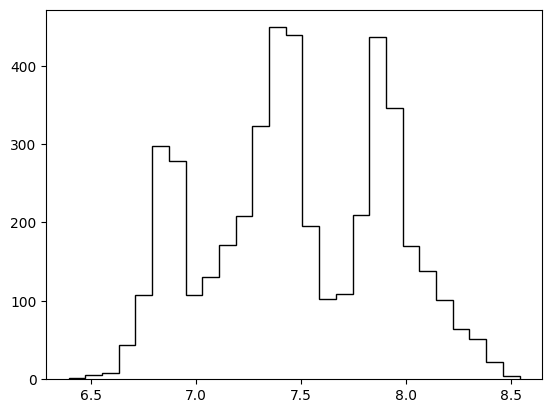

In [239]:
import matplotlib.pyplot as plt

plt.hist(df["log_gdp"].values, histtype="step", color="k", bins="fd");

The trimodality of the data is somewhat hidden when plotting against the unnormalized score and bias-corrected score. However, after log transformation, the structure becomes visible again:

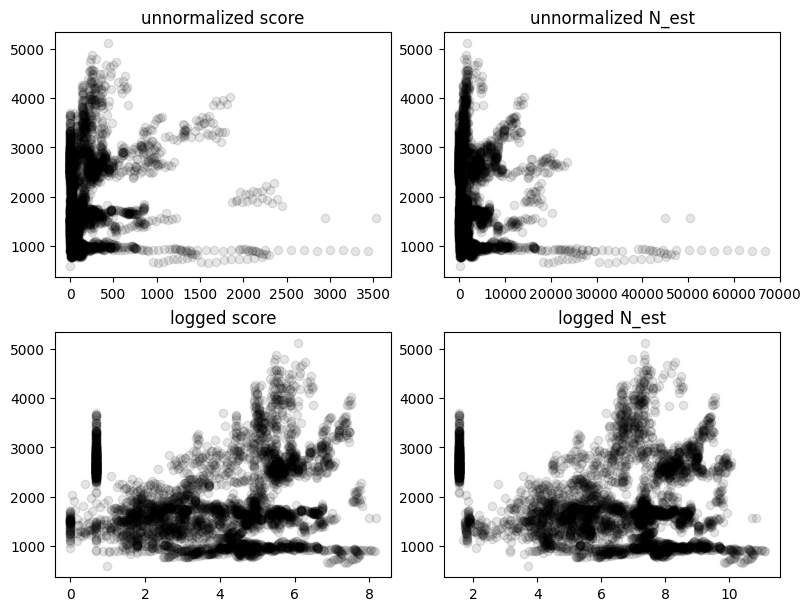

In [240]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), constrained_layout=True)
axes = axes.flatten()

axes[0].scatter(df["score"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[0].set_title("unnormalized score")

axes[1].scatter(df["N_est"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[1].set_title("unnormalized N_est")

axes[2].scatter(df["score_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[2].set_title("logged score")

axes[3].scatter(df["N_est_log"], df["gdp_per_capita"], alpha=0.1, color="k")
axes[3].set_title("logged N_est");

## Regression Analysis: Setting a Baseline

In our attempt to model the relationship between per capita GDP and cultural production, we utilize linear regression models. By progressively developing more intricate models, we evaluate them via approximate leave-one-out cross-validation (LOO). Initially, we establish a global relationship model that doesn't account for any regional differentiation. The model is specified as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta x_i \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In this model, $\alpha$ stands for the intercept and $\beta$ denotes the coefficient of the production score.

In [7]:
models = {}

The model is easily translated to Bambi with:

In [8]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score = bmb.Model(
    f"log_gdp_std ~ score_log_std", df, family="gaussian", priors=priors)

The model graph looks as follows:

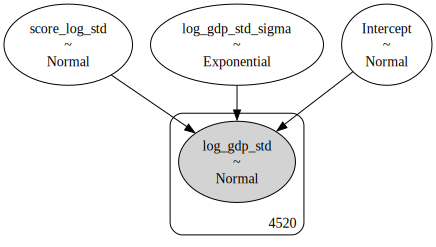

In [9]:
m_score.build()
m_score.graph()

Since this is a relatively simple model, we tune the sampler for 1000 timesteps and draw 1000 samples from the posterior:

In [10]:
fit_score = m_score.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ score_log_std"] = fit_score

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


A quick summary of the model wth ArViz indicates that globally, the cultural production score does _not_ have a pronounced effect:

In [11]:
az.summary(models["gdp ~ score_log_std"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   
Intercept          1.001  0.002   0.998    1.004        0.0      0.0  \
score_log_std     -0.001  0.002  -0.004    0.002        0.0      0.0   
log_gdp_std_sigma  0.057  0.001   0.056    0.058        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            6096.0    3081.0    1.0  
score_log_std        5509.0    3024.0    1.0  
log_gdp_std_sigma    5663.0    2797.0    1.0

Consequently, the lackluster model fit is somewhat expected. To further examine this, we conduct a posterior predictive check where we plot the estimated posterior against the observed GDP distribution. Evidently, the model falls short in fitting the trimodal structure of the data:

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


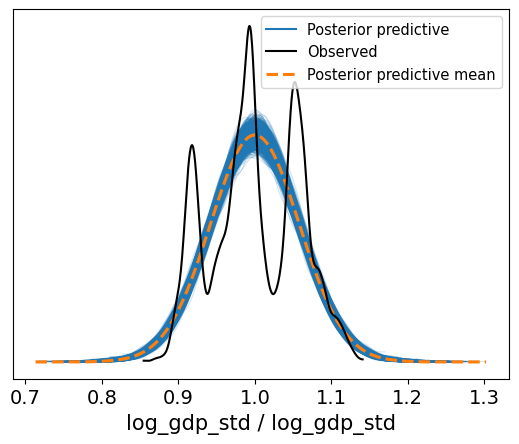

In [12]:
m_score.predict(fit_score, kind="pps")
az.plot_ppc(fit_score);

When we map the predictive posterior slopes against the empirical data in a scatter plot, it reaffirms our previous observation: the model is inadequate in accurately characterizing the data:

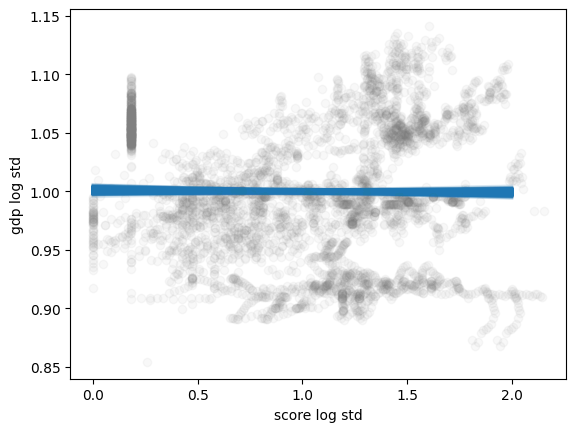

In [13]:
score_log_std_new = np.linspace(0, 2, num=200)
m_score.predict(fit_score, data=pd.DataFrame({"score_log_std": score_log_std_new}))
gdp = fit_score.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(score_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["score_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="score log std", ylabel="gdp log std");

We juxtapose this model with another where we employ the bias-corrected cultural production score as opposed to the unnormalized score. While the model specification remains consistent, its implementation unfolds as follows:

In [14]:
m_est = bmb.Model(
    f"log_gdp_std ~ N_est_log_std", df, family="gaussian", priors=priors)
fit_est = m_est.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
models[f"gdp ~ N_est_log_std"] = fit_est

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


A cursory analysis of the model seems to suggest a negative correlation between the cultural production score and GDP, contrary to our expectations."

In [15]:
az.summary(models["gdp ~ N_est_log_std"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   
Intercept          1.028  0.002   1.024    1.033        0.0      0.0  \
N_est_log_std     -0.028  0.002  -0.032   -0.024        0.0      0.0   
log_gdp_std_sigma  0.056  0.001   0.055    0.057        0.0      0.0   

                   ess_bulk  ess_tail  r_hat  
Intercept            6191.0    3200.0    1.0  
N_est_log_std        6584.0    2991.0    1.0  
log_gdp_std_sigma    7120.0    3171.0    1.0

This negative relationship is visualized in the following graph:

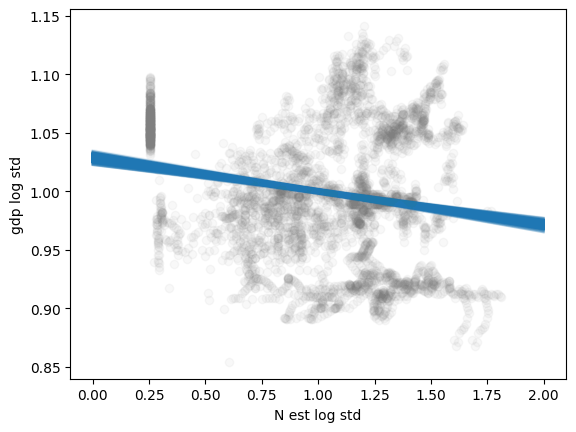

In [16]:
N_est_log_std_new = np.linspace(0, 2, num=200)
m_est.predict(fit_est, data=pd.DataFrame({"N_est_log_std": N_est_log_std_new}))
gdp = fit_est.posterior["log_gdp_std_mean"].sel(draw=slice(0, None, 5))

fig, ax = plt.subplots()
ax.plot(N_est_log_std_new, gdp.stack(samples=("chain", "draw")), color=f"C0", alpha=0.1)

ax.plot(df["N_est_log_std"], df["log_gdp_std"], 'o', color="grey", alpha=0.05, zorder=-5)
ax.set(xlabel="N est log std", ylabel="gdp log std");

However, as indicated by the posterior predictive check, the model fit continues to disappointingly underperform:

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


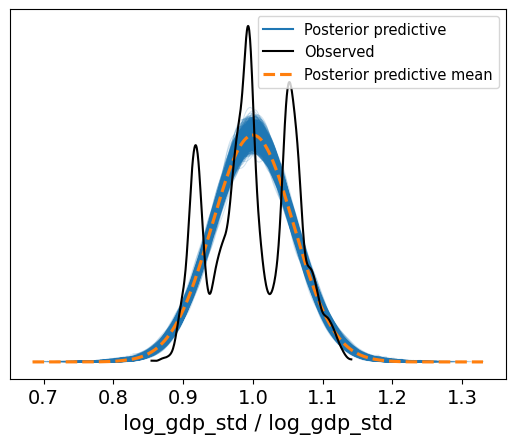

In [17]:
m_est.predict(fit_est, kind="pps")
az.plot_ppc(fit_est);

We utilize WAIC (Widely Applicable Information Criterion) or LOO to compare these models. This evaluation shows that the model incorporating the bias-corrected production variable outperforms the one using the unnormalized variable. Nevertheless, as previously observed, both models exhibit subpar performance, suggesting caution in drawing any conclusions from this comparison. Overall, there appears to be no distinct relationship between the variables and, if any, it seems to contradict our initial expectations.

In [18]:
waic_compare = az.compare(models, ic='WAIC')
waic_compare

rank    elpd_waic    p_waic  elpd_diff        weight   
gdp ~ N_est_log_std     0  6598.028632  2.430713   0.000000  1.000000e+00  \
gdp ~ score_log_std     1  6512.456521  2.571777  85.572111  1.305125e-10   

                            se        dse  warning scale  
gdp ~ N_est_log_std  37.335816   0.000000    False   log  
gdp ~ score_log_std  35.145654  12.295782    False   log

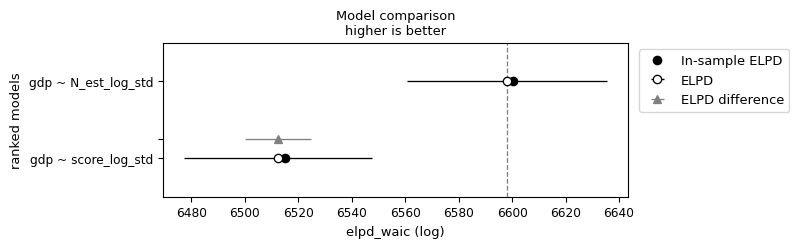

In [19]:
az.plot_compare(waic_compare, insample_dev=True);

## Hierarchical Linear Models

We now progress to a more nuanced analysis that leverages the inherent structure of our data, employing hierarchical linear models. Initially, we implement a rudimentary hierarchical model that only features varying intercepts for regions. This approach models each region as a distinct distribution, each contributing to the global intercept. The specification of the model is as follows:

\begin{align}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]}\\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align} 

In [20]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_vi = bmb.Model(
    "log_gdp_std ~ 1 + (1|region_name)", df, family="gaussian", noncentered=True, priors=priors)
m_vi

       Formula: log_gdp_std ~ 1 + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 4520
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

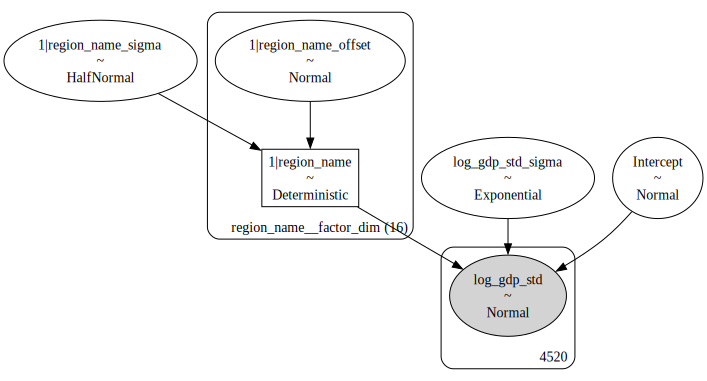

In [21]:
m_vi.build()
m_vi.graph()

The complexity of this model increases slightly, particularly due to the limited data points available for certain regions. Consequently, it's advisable to generate more posterior samples than in the previous models and proceed with a degree of caution while exploring the posterior during the sampling process:

In [22]:
m_vi_fit = m_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,  # more cautious exploration of the posterior
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ (1|region_name)"] = m_vi_fit
az.summary(m_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 151 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean   
Intercept                        0.979  0.014   0.951    1.004        0.0  \
log_gdp_std_sigma                0.024  0.000   0.024    0.025        0.0   
1|region_name_sigma              0.055  0.011   0.037    0.076        0.0   
1|region_name[Arabic world]     -0.047  0.016  -0.077   -0.017        0.0   
1|region_name[Balkans]           0.026  0.016  -0.004    0.056        0.0   
1|region_name[Central Europe]   -0.061  0.014  -0.087   -0.034        0.0   
1|region_name[Chinese world]    -0.032  0.015  -0.060   -0.006        0.0   
1|region_name[Eastern Europe]   -0.061  0.014  -0.088   -0.034        0.0   
1|region_name[France]            0.014  0.014  -0.012    0.041        0.0   
1|region_name[German world]      0.003  0.016  -0.028    0.033        0.0   
1|region_name[Greek World]      -0.047  0.016  -0.077   -0.017        0.0   
1|region_name[Italy]             0.078  0.014   0.052    0.105        0.0   
1|region_name[Japan]            -0.054  0.016  -0.083   -0.024        0.0   
1|region_name[Latin World]       0.078  0.014   0.052    0.105        0.0   
1|region_name[Low countries]     0.090  0.014   0.063    0.116        0.0   
1|region_name[Nordic countries]  0.003  0.014  -0.024    0.029        0.0   
1|region_name[Portugal]          0.003  0.014  -0.022    0.031        0.0   
1|region_name[Spain]            -0.009  0.015  -0.036    0.018        0.0   
1|region_name[United Kingdom]    0.024  0.014  -0.001    0.052        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1037.0    1625.0    1.0  
log_gdp_std_sigma                    0.0    5091.0    4743.0    1.0  
1|region_name_sigma                  0.0    1282.0    2204.0    1.0  
1|region_name[Arabic world]          0.0    1310.0    2276.0    1.0  
1|region_name[Balkans]               0.0    1276.0    2327.0    1.0  
1|region_name[Central Europe]        0.0    1043.0    1678.0    1.0  
1|region_name[Chinese world]         0.0    1077.0    1708.0    1.0  
1|region_name[Eastern Europe]        0.0    1045.0    1616.0    1.0  
1|region_name[France]                0.0    1045.0    1651.0    1.0  
1|region_name[German world]          0.0    1314.0    2311.0    1.0  
1|region_name[Greek World]           0.0    1277.0    2268.0    1.0  
1|region_name[Italy]                 0.0    1045.0    1660.0    1.0  
1|region_name[Japan]                 0.0    1214.0    2054.0    1.0  
1|region_name[Latin World]           0.0    1036.0    1592.0    1.0  
1|region_name[Low countries]         0.0    1046.0    1672.0    1.0  
1|region_name[Nordic countries]      0.0    1037.0    1618.0    1.0  
1|region_name[Portugal]              0.0    1046.0    1667.0    1.0  
1|region_name[Spain]                 0.0    1085.0    1654.0    1.0  
1|region_name[United Kingdom]        0.0    1042.0    1638.0    1.0

The sampling process appears to be effective, characterized by $\hat{r}$ scores hovering around 1 and a satisfactory effective sample size. Below, we provide a forest plot for the varying intercepts. Bear in mind that due to the construction of the model (non-centered), these intercepts should be interpreted as deviations from the global mean intercept, which is not displayed here.

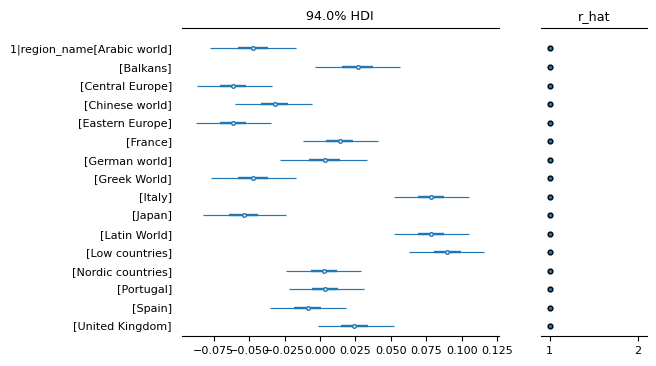

In [23]:
az.plot_forest(
    data=m_vi_fit, 
    figsize=(6, 4), 
    var_names=["1|region_name"], 
    r_hat=True, 
    combined=True, 
    textsize=8
);

Merely by incorporating the hierarchical levels associated with regions, we notice a significant improvement in the model fit, as illustrated in the subsequent posterior predictive check plot:

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


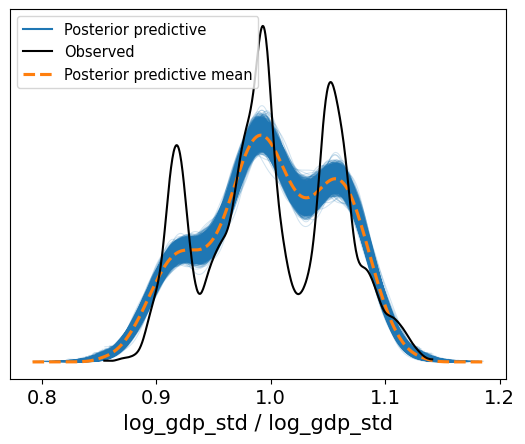

In [24]:
m_vi.predict(m_vi_fit, kind="pps")
az.plot_ppc(m_vi_fit);

### Varying Regions with Global Cultural Production Relationship

It thus seems that allowing variation in GDP per region is useful. We continue experimenting, adding the cultural production both regular and corrected to the model. The model description then becomes:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} \beta x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\text{region}} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

Note that this is essentially the model proposed in the current version of the paper without the variable time. However, including time as a linear predictor will not change the most important lessons of the models below.

In [25]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vi = bmb.Model(
    "log_gdp_std ~ score_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True, 
    priors=priors
)
m_score_vi

       Formula: log_gdp_std ~ score_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 4520
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

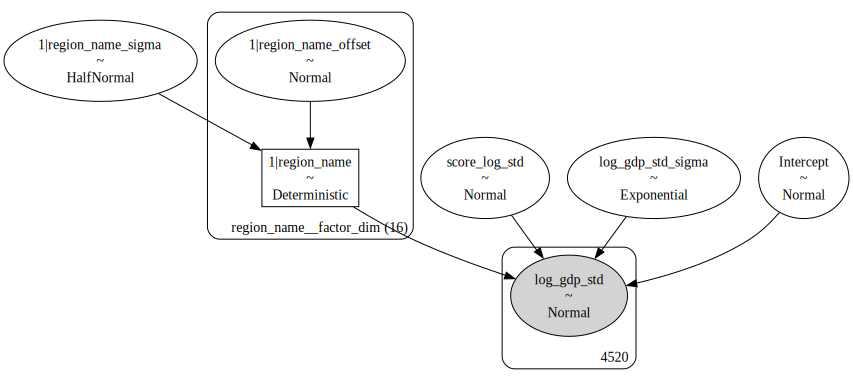

In [26]:
m_score_vi.build()
m_score_vi.graph()

In [27]:
m_score_vi_fit = m_score_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True}
)
models["log_gdp_std ~ score_log_std + (1|region_name)"] = m_score_vi_fit
az.summary(m_score_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 218 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean   
Intercept                        0.952  0.014   0.924    0.979        0.0  \
score_log_std                    0.028  0.001   0.026    0.029        0.0   
log_gdp_std_sigma                0.022  0.000   0.021    0.022        0.0   
1|region_name_sigma              0.055  0.012   0.036    0.077        0.0   
1|region_name[Arabic world]     -0.035  0.016  -0.064   -0.004        0.0   
1|region_name[Balkans]           0.020  0.016  -0.009    0.051        0.0   
1|region_name[Central Europe]   -0.067  0.014  -0.096   -0.041        0.0   
1|region_name[Chinese world]    -0.028  0.015  -0.055    0.000        0.0   
1|region_name[Eastern Europe]   -0.070  0.014  -0.098   -0.044        0.0   
1|region_name[France]            0.008  0.014  -0.021    0.034        0.0   
1|region_name[German world]     -0.019  0.016  -0.052    0.009        0.0   
1|region_name[Greek World]      -0.037  0.016  -0.066   -0.007        0.0   
1|region_name[Italy]             0.067  0.014   0.040    0.095        0.0   
1|region_name[Japan]            -0.048  0.016  -0.077   -0.018        0.0   
1|region_name[Latin World]       0.100  0.014   0.073    0.127        0.0   
1|region_name[Low countries]     0.084  0.014   0.055    0.110        0.0   
1|region_name[Nordic countries]  0.007  0.014  -0.021    0.033        0.0   
1|region_name[Portugal]          0.010  0.014  -0.017    0.037        0.0   
1|region_name[Spain]            -0.011  0.015  -0.038    0.017        0.0   
1|region_name[United Kingdom]    0.022  0.014  -0.005    0.049        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1050.0    1679.0   1.01  
score_log_std                        0.0    5476.0    4633.0   1.00  
log_gdp_std_sigma                    0.0    5232.0    4265.0   1.00  
1|region_name_sigma                  0.0    1317.0    2037.0   1.00  
1|region_name[Arabic world]          0.0    1296.0    2540.0   1.01  
1|region_name[Balkans]               0.0    1229.0    2416.0   1.01  
1|region_name[Central Europe]        0.0    1052.0    1688.0   1.01  
1|region_name[Chinese world]         0.0    1073.0    1748.0   1.01  
1|region_name[Eastern Europe]        0.0    1051.0    1738.0   1.01  
1|region_name[France]                0.0    1048.0    1696.0   1.01  
1|region_name[German world]          0.0    1258.0    2063.0   1.01  
1|region_name[Greek World]           0.0    1297.0    2236.0   1.01  
1|region_name[Italy]                 0.0    1054.0    1694.0   1.01  
1|region_name[Japan]                 0.0    1219.0    2103.0   1.01  
1|region_name[Latin World]           0.0    1052.0    1664.0   1.01  
1|region_name[Low countries]         0.0    1050.0    1694.0   1.01  
1|region_name[Nordic countries]      0.0    1051.0    1719.0   1.01  
1|region_name[Portugal]              0.0    1052.0    1727.0   1.01  
1|region_name[Spain]                 0.0    1089.0    1738.0   1.01  
1|region_name[United Kingdom]        0.0    1053.0    1660.0   1.01

Once again, the sampling appears to be successful, reflected by desirable $\hat{r}$ values and substantial effective sample sizes. The findings hint at a minimal positive global correlation between cultural production and GDP (0.028 CI [0.026, 0.029]). It seems that the model fit has experienced a slight enhancement

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


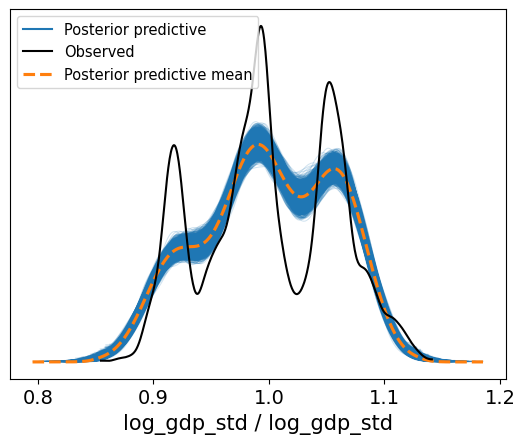

In [28]:
m_score_vi.predict(m_score_vi_fit, kind="pps")
az.plot_ppc(m_score_vi_fit);

Nevertheless, plotting the predictions against the observed data for each region provides more insightful information. This is depicted in the plot below, wherein it's evident that a global predictor of cultural production falls short in fitting the data accurately. Many regions, such as the Low Countries, the Chinese World, or Portugal, exhibit significant residuals, leaving a considerable amount of variation unexplained. Crucially, by assuming the relationship to be exclusively global, we imply it can only be unidirectional --- an assumption that, as we'll soon discover, may not necessarily hold true.

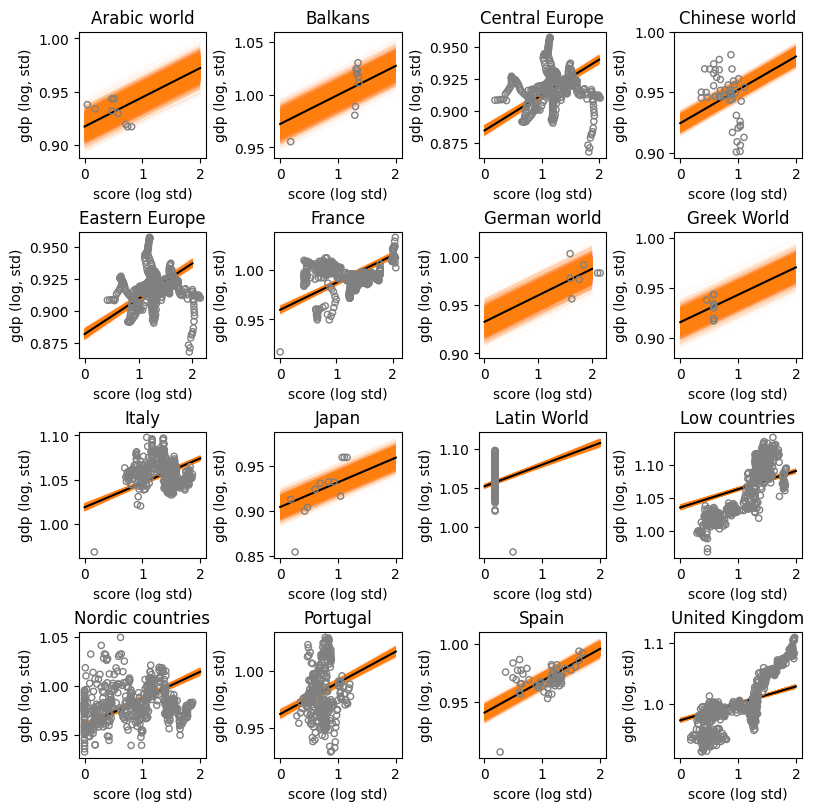

In [29]:
import xarray as xr

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(8, 8), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

Here's another visualization of the posterior predictions: the intercepts differ, but the slope (_by design_) is the same, and thus always positive:

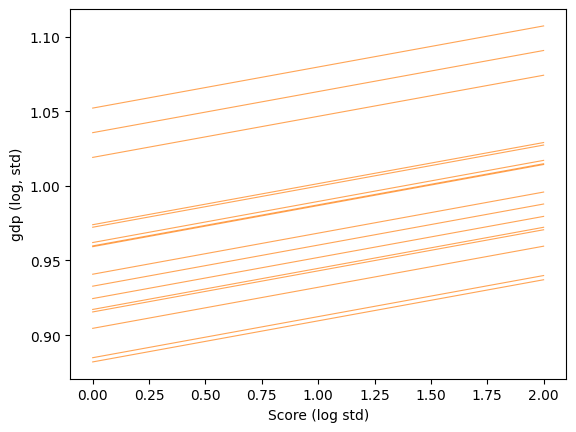

In [30]:
posterior = az.extract(m_score_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["score_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("Score (log std)");

We perform the same analysis, swapping the cultural production score for the bias-corrected score:

In [31]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vi = bmb.Model(
    "log_gdp_std ~ N_est_log_std + (1|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors)
m_est_vi

       Formula: log_gdp_std ~ N_est_log_std + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 4520
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

In [32]:
m_est_vi_fit = m_est_vi.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (1|region_name)"] = m_est_vi_fit
az.summary(m_est_vi_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 223 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean   
Intercept                        0.943  0.014   0.916    0.967        0.0  \
N_est_log_std                    0.036  0.001   0.033    0.039        0.0   
log_gdp_std_sigma                0.022  0.000   0.022    0.023        0.0   
1|region_name_sigma              0.057  0.012   0.037    0.078        0.0   
1|region_name[Arabic world]     -0.036  0.016  -0.064   -0.006        0.0   
1|region_name[Balkans]           0.018  0.016  -0.012    0.047        0.0   
1|region_name[Central Europe]   -0.069  0.014  -0.095   -0.042        0.0   
1|region_name[Chinese world]    -0.025  0.014  -0.052    0.001        0.0   
1|region_name[Eastern Europe]   -0.072  0.014  -0.097   -0.045        0.0   
1|region_name[France]            0.009  0.014  -0.016    0.035        0.0   
1|region_name[German world]     -0.019  0.016  -0.048    0.013        0.0   
1|region_name[Greek World]      -0.037  0.016  -0.067   -0.009        0.0   
1|region_name[Italy]             0.069  0.014   0.044    0.096        0.0   
1|region_name[Japan]            -0.048  0.015  -0.077   -0.021        0.0   
1|region_name[Latin World]       0.105  0.014   0.080    0.131        0.0   
1|region_name[Low countries]     0.088  0.014   0.063    0.115        0.0   
1|region_name[Nordic countries]  0.006  0.014  -0.019    0.032        0.0   
1|region_name[Portugal]          0.007  0.014  -0.019    0.033        0.0   
1|region_name[Spain]            -0.011  0.014  -0.037    0.015        0.0   
1|region_name[United Kingdom]    0.023  0.014  -0.003    0.049        0.0   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                            0.0    1295.0    1866.0   1.00  
N_est_log_std                        0.0    5278.0    4755.0   1.00  
log_gdp_std_sigma                    0.0    5605.0    4811.0   1.00  
1|region_name_sigma                  0.0    1253.0    1999.0   1.01  
1|region_name[Arabic world]          0.0    1542.0    2713.0   1.00  
1|region_name[Balkans]               0.0    1628.0    2944.0   1.00  
1|region_name[Central Europe]        0.0    1306.0    1882.0   1.00  
1|region_name[Chinese world]         0.0    1345.0    1794.0   1.00  
1|region_name[Eastern Europe]        0.0    1308.0    2009.0   1.00  
1|region_name[France]                0.0    1293.0    1873.0   1.00  
1|region_name[German world]          0.0    1665.0    2962.0   1.00  
1|region_name[Greek World]           0.0    1575.0    2721.0   1.00  
1|region_name[Italy]                 0.0    1295.0    1822.0   1.00  
1|region_name[Japan]                 0.0    1576.0    2664.0   1.00  
1|region_name[Latin World]           0.0    1298.0    1909.0   1.00  
1|region_name[Low countries]         0.0    1319.0    1916.0   1.00  
1|region_name[Nordic countries]      0.0    1300.0    1944.0   1.00  
1|region_name[Portugal]              0.0    1312.0    1965.0   1.00  
1|region_name[Spain]                 0.0    1361.0    2060.0   1.00  
1|region_name[United Kingdom]        0.0    1290.0    1936.0   1.00

The fit appears to bear similarity to the prior model, and once more, the incorporated unidirectional relationship yields comparatively large residuals.

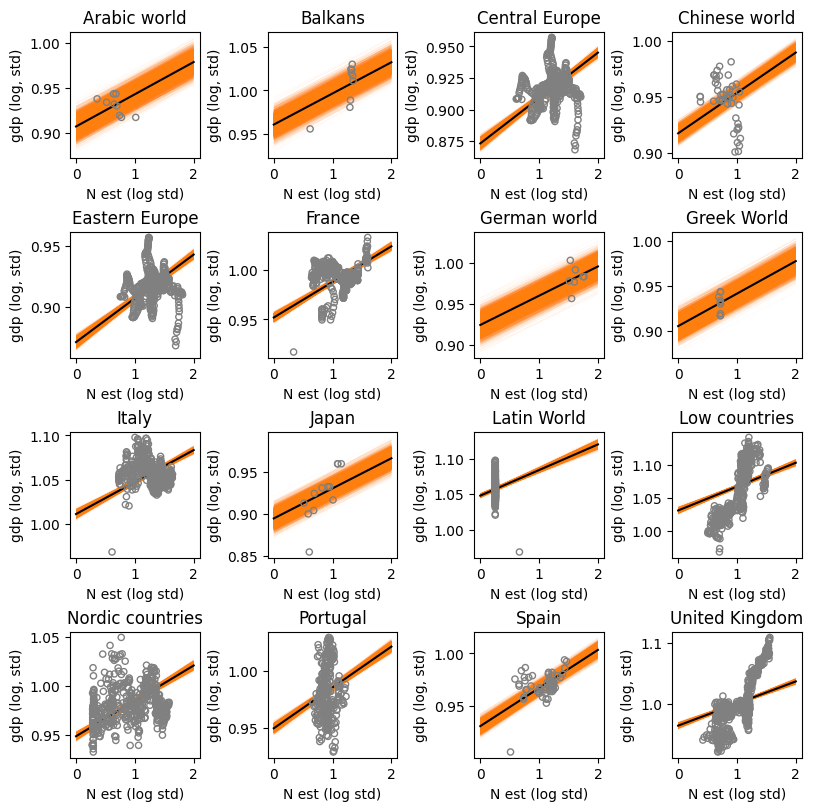

In [33]:
import xarray as xr

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(8, 8), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vi_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = slope_common

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N est (log std)", title=region_name)

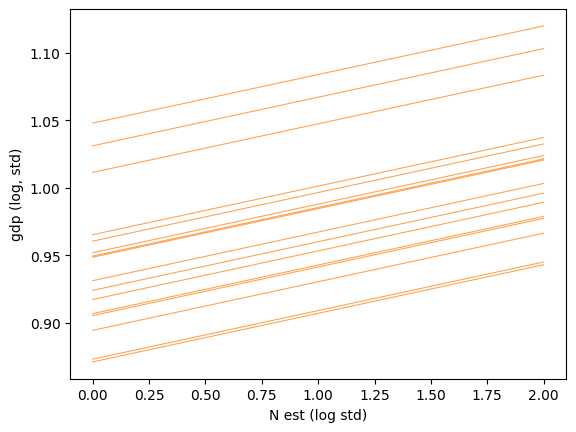

In [34]:
posterior = az.extract(m_est_vi_fit)
intercept_common = posterior["Intercept"]
slope_common = posterior["N_est_log_std"]
score = np.array([0, 2])

intercept_group_specific = posterior["1|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean()
score_xi = xr.DataArray(score)
plt.plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.7, lw=0.8)
plt.ylabel("gdp (log, std)")
plt.xlabel("N est (log std)");

#### Model comparison

We undertake a comparison of all models explored thus far, this time employing approximate leave-one-out cross-validation (LOO). The model incorporating varying intercepts on region and using cultural score as a global predictor appears to best fit the data. As expected, it is closely followed by the model utilizing bias-corrected cultural production scores. All models featuring varying intercepts significantly outperform those with a singular global intercept. The results are demonstrated in the subsequent table and accompanying figure.

In [35]:
waic_compare = az.compare(models, ic='LOO')

In [36]:
waic_compare

rank      elpd_loo      p_loo   
log_gdp_std ~ score_log_std + (1|region_name)     0  10888.618841  16.881311  \
log_gdp_std ~ N_est_log_std + (1|region_name)     1  10746.444043  16.556437   
log_gdp_std ~ (1|region_name)                     2  10418.949591  15.034530   
gdp ~ N_est_log_std                               3   6598.025584   2.433761   
gdp ~ score_log_std                               4   6512.453303   2.574995   

                                                 elpd_diff    weight   
log_gdp_std ~ score_log_std + (1|region_name)     0.000000  0.941746  \
log_gdp_std ~ N_est_log_std + (1|region_name)   142.174798  0.000000   
log_gdp_std ~ (1|region_name)                   469.669250  0.057646   
gdp ~ N_est_log_std                            4290.593258  0.000000   
gdp ~ score_log_std                            4376.165538  0.000608   

                                                      se        dse  warning   
log_gdp_std ~ score_log_std + (1|region_name)  53.303401   0.000000    False  \
log_gdp_std ~ N_est_log_std + (1|region_name)  56.737357   9.484013    False   
log_gdp_std ~ (1|region_name)                  68.448357  34.240872    False   
gdp ~ N_est_log_std                            37.335864  55.763643    False   
gdp ~ score_log_std                            35.145705  57.014657    False   

                                              scale  
log_gdp_std ~ score_log_std + (1|region_name)   log  
log_gdp_std ~ N_est_log_std + (1|region_name)   log  
log_gdp_std ~ (1|region_name)                   log  
gdp ~ N_est_log_std                             log  
gdp ~ score_log_std                             log

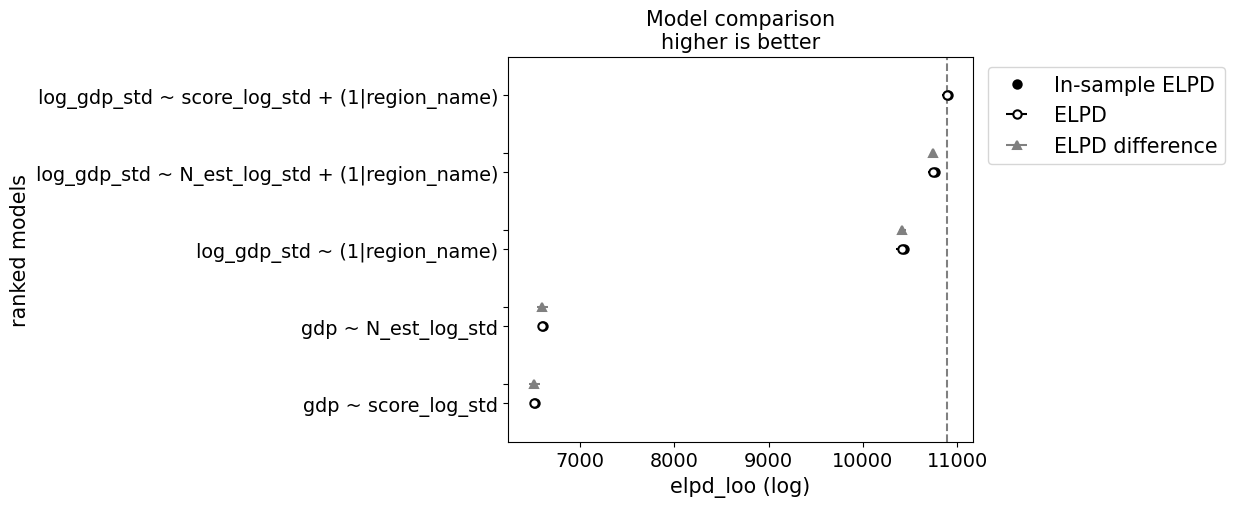

In [37]:
az.plot_compare(waic_compare, insample_dev=True);

/usr/local/lib/python3.11/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


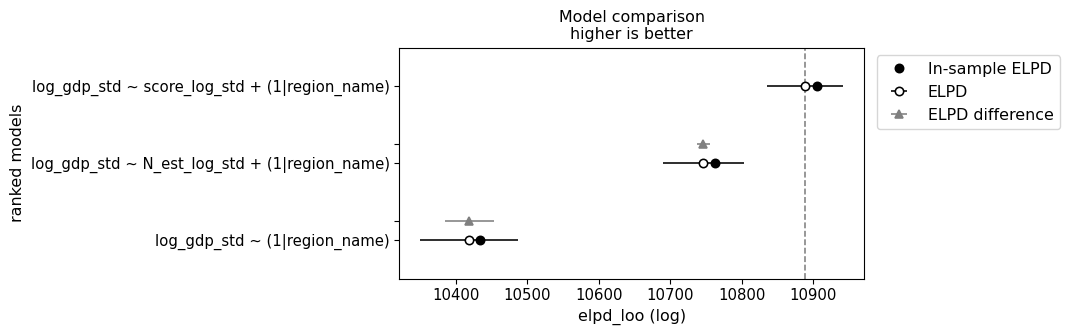

In [38]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("1|region_name")], insample_dev=True);

### Varying Slopes for Cultural Production in Different Regions

In our previous analysis, we presumed a global, uniform effect of cultural production on GDP per capita. However, upon observing significant discrepancies in the GDP intercepts per region, it's plausible that the relationship's slope between the cultural production score and GDP also varies. To cater to this, we construct a varying slope model with the following specification:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} + (\beta + \beta_{\text{region}[i]}) x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\alpha}) \\
\beta_\text{region} & \sim \text{Normal}(0, \sigma_{\beta}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
\sigma_{\alpha} & \sim \text{HalfNormal}(1) \\
\sigma_{\beta} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*} 

As daunting as this might seem, it can be implemented relatively straightforward, as shown below. Also note that we could further improve the model by modeling the dependence of the priors on the varying slopes and intercepts. For now we treat them as independent priors, which may not be the most efficient way to do it.

In [39]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "score_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_score_vs = bmb.Model(
    "log_gdp_std ~ score_log_std + (score_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_score_vs

       Formula: log_gdp_std ~ score_log_std + (score_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 4520
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            score_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            score_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

The model graph looks as follows:

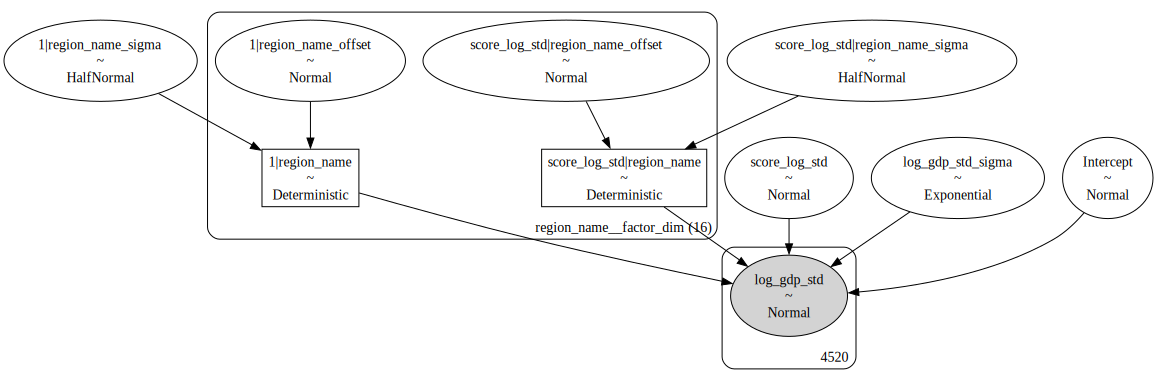

In [40]:
m_score_vs.build()
m_score_vs.graph()

Despite a considerable surge in the model's complexity, efficient sampling persists, marked by commendable $\hat{r}$ values and satisfactory effective sample sizes. The model's summary is provided below. A key observation we promptly make is the elimination of the unmistakably positive main, global effect of the cultural production score. Instead, it intersects 0 within the 97% confidence intervals, suggesting the effect is not solely positive. We'll elaborate on this further in the ensuing section.

In [41]:
m_score_vs_fit = m_score_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.9,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_log_std + (score_log_std|region_name)"] = m_score_vs_fit
az.summary(m_score_vs_fit)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, score_log_std, 1|region_name_sigma, 1|region_name_offset, score_log_std|region_name_sigma, score_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 751 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%   
Intercept                                    0.965  0.015   0.935    0.993  \
score_log_std                                0.003  0.016  -0.029    0.033   
log_gdp_std_sigma                            0.017  0.000   0.017    0.017   
1|region_name_sigma                          0.058  0.012   0.038    0.080   
score_log_std|region_name_sigma              0.060  0.017   0.032    0.091   
1|region_name[Arabic world]                 -0.022  0.019  -0.057    0.014   
1|region_name[Balkans]                      -0.015  0.023  -0.058    0.027   
1|region_name[Central Europe]               -0.047  0.016  -0.075   -0.016   
1|region_name[Chinese world]                 0.020  0.018  -0.013    0.053   
1|region_name[Eastern Europe]               -0.045  0.016  -0.073   -0.014   
1|region_name[France]                        0.024  0.015  -0.007    0.051   
1|region_name[German world]                  0.003  0.038  -0.068    0.074   
1|region_name[Greek World]                  -0.023  0.032  -0.083    0.035   
1|region_name[Italy]                         0.102  0.016   0.073    0.133   
1|region_name[Japan]                        -0.087  0.019  -0.123   -0.052   
1|region_name[Latin World]                   0.117  0.018   0.085    0.152   
1|region_name[Low countries]                 0.004  0.015  -0.024    0.034   
1|region_name[Nordic countries]              0.012  0.015  -0.018    0.041   
1|region_name[Portugal]                      0.008  0.016  -0.022    0.038   
1|region_name[Spain]                        -0.010  0.017  -0.041    0.022   
1|region_name[United Kingdom]               -0.039  0.015  -0.069   -0.010   
score_log_std|region_name[Arabic world]     -0.028  0.025  -0.075    0.020   
score_log_std|region_name[Balkans]           0.043  0.022   0.004    0.085   
score_log_std|region_name[Central Europe]   -0.005  0.017  -0.035    0.028   
score_log_std|region_name[Chinese world]    -0.052  0.019  -0.091   -0.018   
score_log_std|region_name[Eastern Europe]   -0.006  0.017  -0.037    0.026   
score_log_std|region_name[France]           -0.001  0.017  -0.031    0.031   
score_log_std|region_name[German world]      0.004  0.026  -0.042    0.055   
score_log_std|region_name[Greek World]      -0.024  0.051  -0.121    0.068   
score_log_std|region_name[Italy]            -0.011  0.017  -0.043    0.020   
score_log_std|region_name[Japan]             0.059  0.021   0.019    0.100   
score_log_std|region_name[Latin World]      -0.142  0.052  -0.246   -0.052   
score_log_std|region_name[Low countries]     0.080  0.017   0.050    0.113   
score_log_std|region_name[Nordic countries]  0.002  0.017  -0.028    0.034   
score_log_std|region_name[Portugal]          0.009  0.017  -0.023    0.042   
score_log_std|region_name[Spain]             0.010  0.018  -0.025    0.042   
score_log_std|region_name[United Kingdom]    0.069  0.017   0.039    0.101   

                                             mcse_mean  mcse_sd  ess_bulk   
Intercept                                        0.000    0.000    1933.0  \
score_log_std                                    0.000    0.000    1998.0   
log_gdp_std_sigma                                0.000    0.000   10155.0   
1|region_name_sigma                              0.000    0.000    2882.0   
score_log_std|region_name_sigma                  0.000    0.000    2048.0   
1|region_name[Arabic world]                      0.000    0.000    2709.0   
1|region_name[Balkans]                           0.000    0.000    3818.0   
1|region_name[Central Europe]                    0.000    0.000    1990.0   
1|region_name[Chinese world]                     0.000    0.000    2469.0   
1|region_name[Eastern Europe]                    0.000    0.000    1935.0   
1|region_name[France]                            0.000    0.000    1935.0   
1|region_name[German world]                      0.000    0.000    7212.0   
1|region_name[Greek World]                       0.000    0.000    4647.0   
1|r

Echoing our previous approach, we conduct a posterior predictive check and find that the model aligns with the data far more effectively. The difference with the simpler models is really remarkable:

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


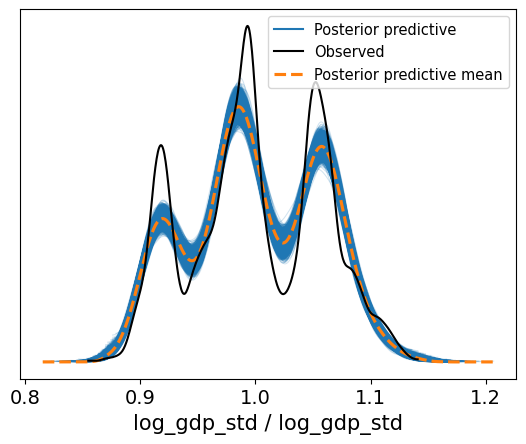

In [42]:
m_score_vs.predict(m_score_vs_fit, kind="pps")
az.plot_ppc(m_score_vs_fit);

The superior model fit becomes palpably apparent when we map the posterior predictions against the observations per region. In most instances, the varying slopes seem to align seamlessly with the data. A vital insight garnered from this plot is that the relationship between GDP and cultural production isn't universally positive across all regions. A pronounced positive correlation between the two variables is noticeable for the Low Countries, the United Kingdom, Japan, and to a slightly lesser degree, Spain. Conversely, the relationship appears inverted for the Chinese World, Eastern Europe, Italy, and the Arabic World. Portugal, France, and Central Europe do not appear to exhibit a distinct relationship, neither positive nor negative.

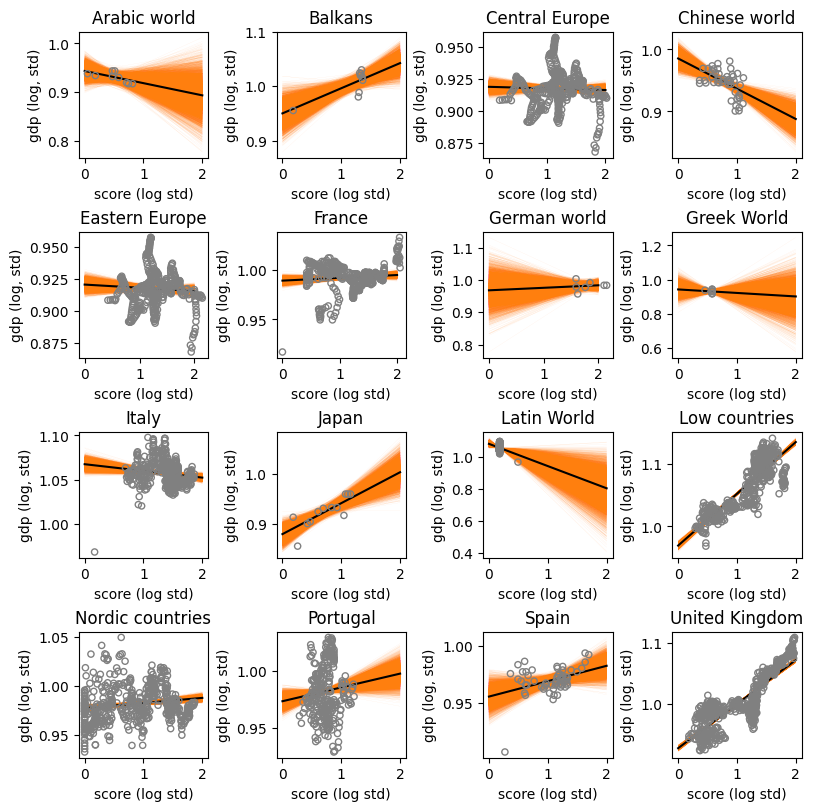

In [43]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(8, 8), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_score_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["score_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["score_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["score_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="score (log std)", title=region_name)

The ensuing plot illustrates the mean posterior distribution for each region, facilitating a more discernible understanding of regions that showcase a positive correlation between GDP and cultural production, and those that bear a negative or ambiguous relationship. The plot vividly indicates that some regions maintain a positive association, while others harbor a negative one. Thus, this analysis affirms that the incorporation of varying slopes in our model was justified and introduces valuable nuance to our exploration. **It underlines that we cannot unequivocally assert a positive correlation between cultural production and GDP, as this relationship varies by region.**

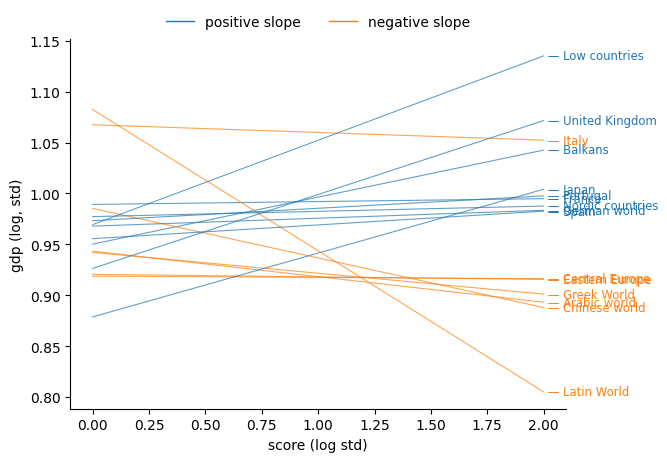

In [44]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["score_log_std|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean() + slope_group_specific.mean("sample")
score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():
    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    Y = (a_region + b_region * score_xi).T
    color = "C0" if (Y[1] - Y[0]) > 0 else "C1"
    ax.plot(score_xi, Y, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=f"C{i}", lw=1) for i in (0, 1)]
ax.legend(custom_lines, ['positive slope', 'negative slope'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="score (log std)");

#### Covarying slopes and intercepts

To further scrutinize the region-specific slope attributes, we illustrate the covariance between region-specific intercepts and slopes. The hypothesis is the potential correlation between the intercepts and slopes, which may indicate, for instance, an enhanced or diminished GDP increase or decrease corresponding to higher or lower intercepts. The ensuing plot depicts this relationship. Although most regions don't seem to manifest a distinctly pronounced relationship between intercepts and slopes, there are a handful of intriguing cases where interaction is noticeable. For instance, in the German world, the Greek world, and in the Latin world, a negative correlation is observed, implying a decrease in slope as the intercept escalates. Contrarily, regions like the Low Countries, although having an average intercept (hence its position around zero), boast an above-average slope. On the other hand, the Chinese world, despite having an average intercept, showcases a below-average slope.

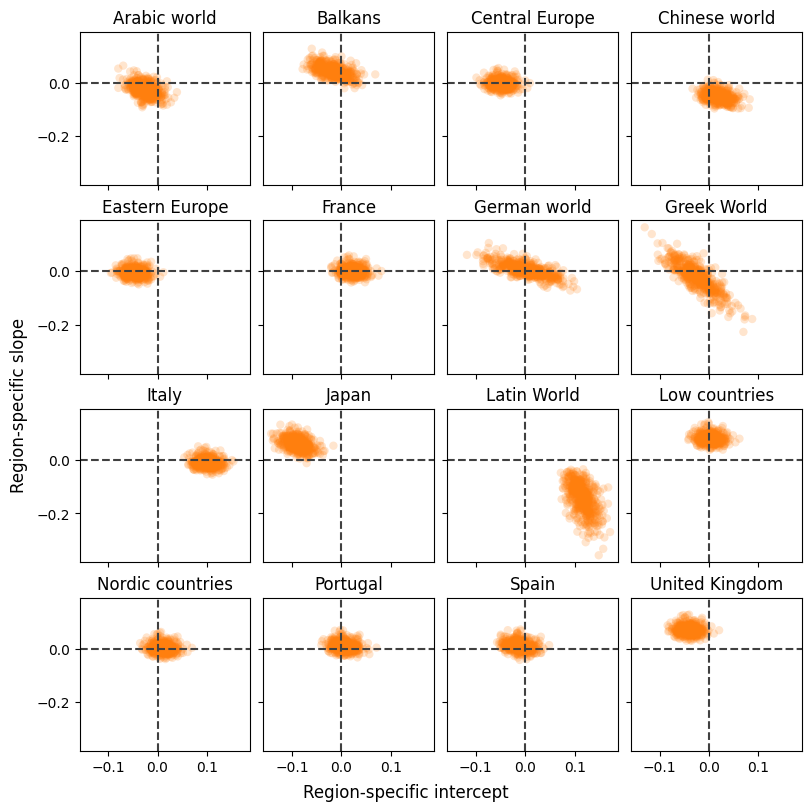

In [176]:
import matplotlib

regions = df["region_name"].unique()

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(8, 8), sharex=True, sharey=True, constrained_layout=True)

# #  extract a subsample from the posterior and stack the chain and draw dims
posterior = az.extract(m_score_vs_fit, num_samples=500)
for i, (region, ax) in enumerate(zip(regions, axes.flatten())):
    post = posterior.sel(region_name__factor_dim=region)
    X = post["1|region_name"].data
    Y = post["score_log_std|region_name"].data
    ax.scatter(
        X, Y,
        facecolor="C1", edgecolor="none", alpha=0.2)
    ax.set(title=region)

    ax.axhline(c="0.25", ls="--")
    ax.axvline(c="0.25", ls="--")
    
fig.supylabel('Region-specific slope')
fig.supxlabel('Region-specific intercept');
plt.savefig("covariance-plot.pdf")

Below, I repeat the analysis, again swapping cultural production for the bias-corrected score.

In [177]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "N_est_log_std|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}

m_est_vs = bmb.Model(
    "log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)", 
    df, 
    family="gaussian", 
    noncentered=True,
    priors=priors
)
m_est_vs

       Formula: log_gdp_std ~  N_est_log_std + (N_est_log_std|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 4520
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0, sigma: 1.0)
            N_est_log_std ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
            N_est_log_std|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 1.0))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ Exponential(lam: 1.0)

In [178]:
m_est_vs_fit = m_est_vs.fit(
    draws=2000, 
    chains=4, 
    target_accept=0.95,
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ N_est_log_std + (N_est_log_std|region_name)"] = m_est_vs_fit
az.summary(m_est_vs_fit)

# NB: hitting max_treedepth is not much of a concern, at least not for model validity
# For more information about this and other warnings, see https://mc-stan.org/misc/warnings.html
# TODO, see if we can improve efficiency

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_gdp_std_sigma, Intercept, N_est_log_std, 1|region_name_sigma, 1|region_name_offset, N_est_log_std|region_name_sigma, N_est_log_std|region_name_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1019 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


mean     sd  hdi_3%  hdi_97%   
Intercept                                    0.955  0.020   0.917    0.992  \
N_est_log_std                                0.014  0.021  -0.026    0.053   
log_gdp_std_sigma                            0.017  0.000   0.017    0.018   
1|region_name_sigma                          0.074  0.016   0.047    0.104   
N_est_log_std|region_name_sigma              0.080  0.019   0.050    0.116   
1|region_name[Arabic world]                 -0.004  0.028  -0.056    0.049   
1|region_name[Balkans]                      -0.036  0.033  -0.097    0.027   
1|region_name[Central Europe]               -0.038  0.020  -0.077    0.001   
1|region_name[Chinese world]                 0.037  0.023  -0.007    0.079   
1|region_name[Eastern Europe]               -0.034  0.020  -0.072    0.005   
1|region_name[France]                        0.033  0.020  -0.004    0.072   
1|region_name[German world]                  0.003  0.056  -0.107    0.106   
1|region_name[Greek World]                  -0.018  0.047  -0.105    0.071   
1|region_name[Italy]                         0.119  0.020   0.080    0.158   
1|region_name[Japan]                        -0.106  0.026  -0.156   -0.056   
1|region_name[Latin World]                   0.141  0.022   0.100    0.184   
1|region_name[Low countries]                -0.029  0.020  -0.066    0.011   
1|region_name[Nordic countries]              0.019  0.020  -0.019    0.057   
1|region_name[Portugal]                      0.009  0.022  -0.031    0.051   
1|region_name[Spain]                        -0.006  0.022  -0.047    0.038   
1|region_name[United Kingdom]               -0.085  0.020  -0.122   -0.047   
N_est_log_std|region_name[Arabic world]     -0.044  0.035  -0.112    0.019   
N_est_log_std|region_name[Balkans]           0.057  0.029  -0.001    0.110   
N_est_log_std|region_name[Central Europe]   -0.014  0.021  -0.054    0.025   
N_est_log_std|region_name[Chinese world]    -0.070  0.024  -0.116   -0.023   
N_est_log_std|region_name[Eastern Europe]   -0.017  0.021  -0.058    0.021   
N_est_log_std|region_name[France]           -0.009  0.021  -0.048    0.032   
N_est_log_std|region_name[German world]      0.001  0.038  -0.069    0.076   
N_est_log_std|region_name[Greek World]      -0.022  0.063  -0.146    0.094   
N_est_log_std|region_name[Italy]            -0.027  0.021  -0.065    0.014   
N_est_log_std|region_name[Japan]             0.076  0.029   0.019    0.129   
N_est_log_std|region_name[Latin World]      -0.165  0.044  -0.253   -0.087   
N_est_log_std|region_name[Low countries]     0.123  0.021   0.084    0.164   
N_est_log_std|region_name[Nordic countries] -0.005  0.021  -0.045    0.034   
N_est_log_std|region_name[Portugal]          0.007  0.023  -0.037    0.049   
N_est_log_std|region_name[Spain]             0.006  0.023  -0.038    0.047   
N_est_log_std|region_name[United Kingdom]    0.114  0.021   0.076    0.155   

                                             mcse_mean  mcse_sd  ess_bulk   
Intercept                                        0.000    0.000    1971.0  \
N_est_log_std                                    0.000    0.000    1750.0   
log_gdp_std_sigma                                0.000    0.000   10553.0   
1|region_name_sigma                              0.000    0.000    2564.0   
N_est_log_std|region_name_sigma                  0.000    0.000    2661.0   
1|region_name[Arabic world]                      0.000    0.000    3317.0   
1|region_name[Balkans]                           0.000    0.000    4507.0   
1|region_name[Central Europe]                    0.000    0.000    2028.0   
1|region_name[Chinese world]                     0.000    0.000    2404.0   
1|region_name[Eastern Europe]                    0.000    0.000    2045.0   
1|region_name[France]                            0.000    0.000    1993.0   
1|region_name[German world]                      0.001    0.001    6604.0   
1|region_name[Greek World]                       0.001    0.001    5349.0   
1|r

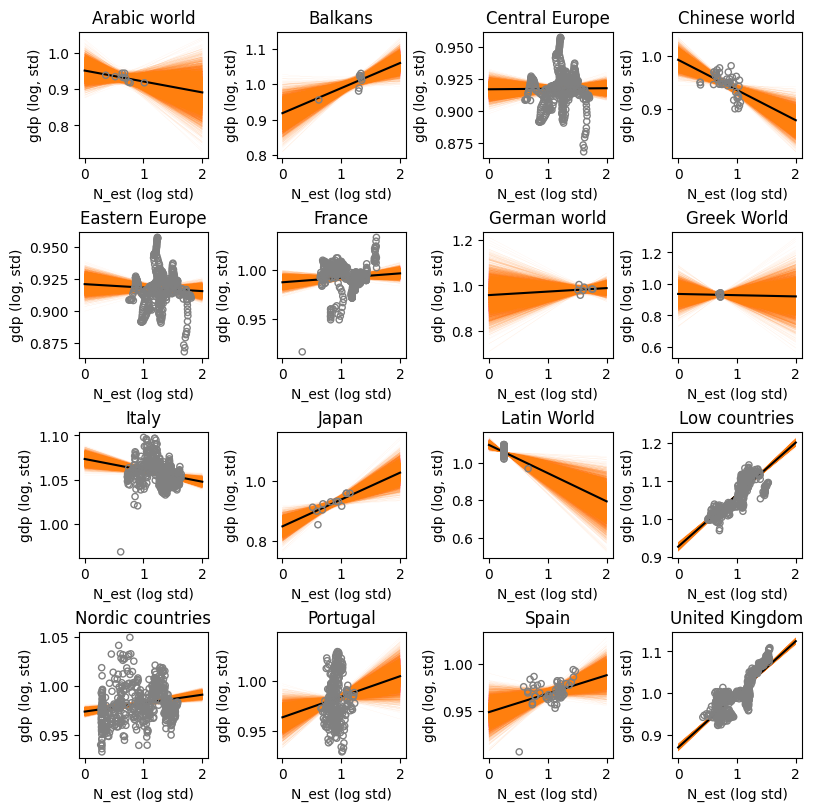

In [179]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(8, 8), constrained_layout=True)
axes = axes.flatten()

for i, region_name in enumerate(df["region_name"].unique()):

    data_0 = df[df["region_name"] == region_name]

    posterior = az.extract(m_est_vs_fit)
    intercept_common = posterior["Intercept"]
    slope_common = posterior["N_est_log_std"]
    score = np.array([0, 2])

    intercept_specific_0 = posterior["1|region_name"].sel(region_name__factor_dim=region_name)
    slope_specific_0 = posterior["N_est_log_std|region_name"].sel(region_name__factor_dim=region_name)
    a = (intercept_common + intercept_specific_0)
    b = (slope_common + slope_specific_0)

    score_xi = xr.DataArray(score)
    axes[i].plot(score_xi, (a + b * score_xi).T, color="C1", alpha=0.2, lw=0.1)
    axes[i].plot(score_xi, a.mean() + b.mean() * score_xi, color="black")
    axes[i].scatter(data_0["N_est_log_std"], data_0["log_gdp_std"], zorder=2, s=20, 
                    facecolors="none", edgecolors='grey')
    axes[i].set(ylabel="gdp (log, std)", xlabel="N_est (log std)", title=region_name)

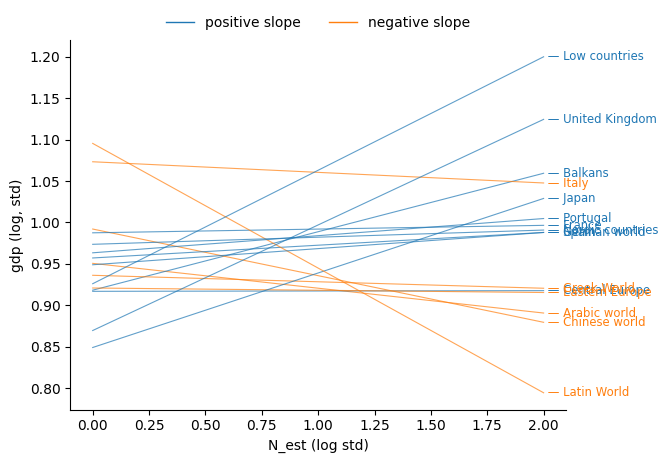

In [180]:
from matplotlib.lines import Line2D

intercept_group_specific = posterior["1|region_name"]
slope_group_specific = posterior["N_est_log_std|region_name"]
a = intercept_common.mean() + intercept_group_specific.mean("sample")
b = slope_common.mean() + slope_group_specific.mean("sample")
score_xi = xr.DataArray(score)

fig, ax = plt.subplots()
for region in df["region_name"].unique():
    a_region = a.sel(region_name__factor_dim=region)
    b_region = b.sel(region_name__factor_dim=region)
    Y = (a_region + b_region * score_xi).T
    color = "C0" if (Y[1] - Y[0]) > 0 else "C1"
    ax.plot(score_xi, Y, color=color, alpha=0.7, lw=0.8, label=region)
    ax.text(
        score_xi[-1],
        Y[-1],
        " — " + region,
        size="small",
        color=color,
        ha="left",
        va="center",
    )
    
ax.spines[['right', 'top']].set_visible(False)
custom_lines = [Line2D([0], [0], color=f"C{i}", lw=1) for i in (0, 1)]
ax.legend(custom_lines, ['positive slope', 'negative slope'], 
           loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.1), frameon=False)
ax.set(ylabel="gdp (log, std)", xlabel="N_est (log std)");

#### Model comparison

Finally, we execute a comparison across all models evaluated thus far. The comparison decisively underscores that incorporating varying slopes dramatically enhances the model fit, considerably outpacing the performance of the other models.

In [181]:
waic_compare = az.compare(models, ic='LOO')
waic_compare

/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank      elpd_loo   
log_gdp_std ~ score_log_std + (score_log_std|re...     0  12007.296842  \
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...     1  11865.050793   
log_gdp_std ~ score_log_std + (1|region_name)          2  10888.618841   
log_gdp_std ~ N_est_log_std + (1|region_name)          3  10746.444043   
log_gdp_std ~ (1|region_name)                          4  10418.949591   
gdp ~ N_est_log_std                                    5   6598.025584   
gdp ~ score_log_std                                    6   6512.453303   

                                                        p_loo    elpd_diff   
log_gdp_std ~ score_log_std + (score_log_std|re...  36.655321     0.000000  \
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  32.685200   142.246048   
log_gdp_std ~ score_log_std + (1|region_name)       16.881311  1118.678000   
log_gdp_std ~ N_est_log_std + (1|region_name)       16.556437  1260.852798   
log_gdp_std ~ (1|region_name)                       15.034530  1588.347250   
gdp ~ N_est_log_std                                  2.433761  5409.271258   
gdp ~ score_log_std                                  2.574995  5494.843539   

                                                          weight         se   
log_gdp_std ~ score_log_std + (score_log_std|re...  9.482908e-01  57.377039  \
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  2.042143e-10  57.696776   
log_gdp_std ~ score_log_std + (1|region_name)       2.014570e-02  53.303401   
log_gdp_std ~ N_est_log_std + (1|region_name)       0.000000e+00  56.737357   
log_gdp_std ~ (1|region_name)                       3.145571e-02  68.448357   
gdp ~ N_est_log_std                                 2.669831e-10  37.335864   
gdp ~ score_log_std                                 1.078128e-04  35.145705   

                                                          dse  warning scale  
log_gdp_std ~ score_log_std + (score_log_std|re...   0.000000     True   log  
log_gdp_std ~ N_est_log_std + (N_est_log_std|re...  13.513708     True   log  
log_gdp_std ~ score_log_std + (1|region_name)       52.591858    False   log  
log_gdp_std ~ N_est_log_std + (1|region_name)       57.069566    False   log  
log_gdp_std ~ (1|region_name)                       70.858057    False   log  
gdp ~ N_est_log_std                                 65.120625    False   log  
gdp ~ score_log_std                                 65.071798    False   log

/usr/local/lib/python3.11/site-packages/arviz/plots/compareplot.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df.sort_values(by="rank", inplace=True)


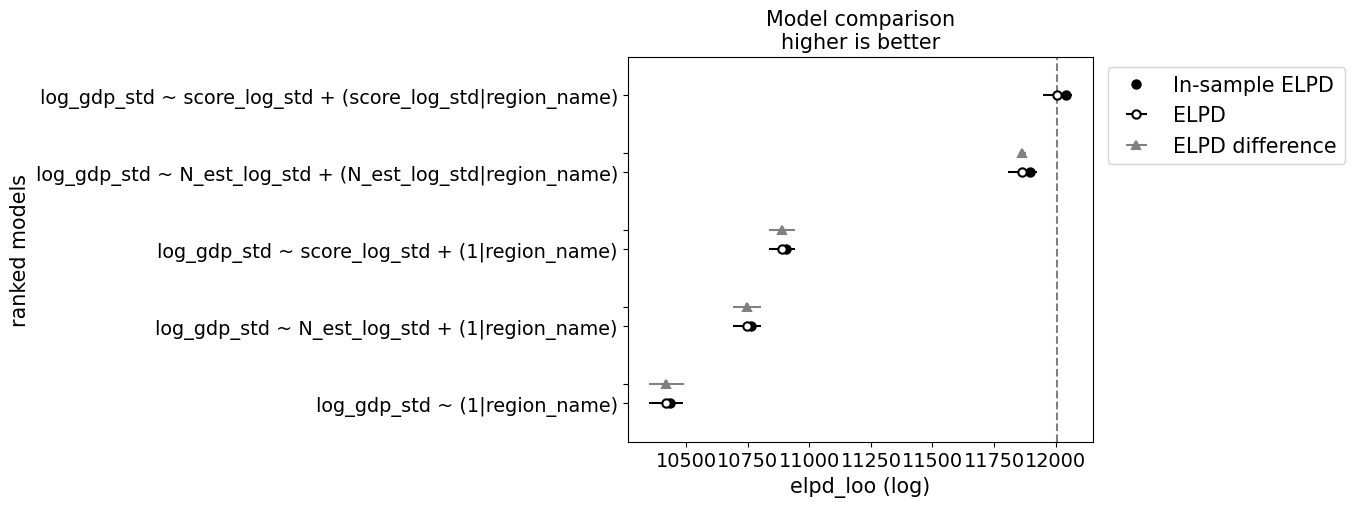

In [182]:
az.plot_compare(waic_compare.loc[waic_compare.index.str.contains("region_name")], insample_dev=True);

## Modeling time

So far, we haven't factored in the element of time. Undeniably, time can be complex to model, particularly when it spans an extensive period as in our case. Taking inspiration from McElreath's (2020) Cherry Blossom example, we plan to utilize "Basis Splines," or "B-Splines" for brevity, as our approach to model time. Before we get into the model details, let's first explore the values of GDP for each year in the dataset.

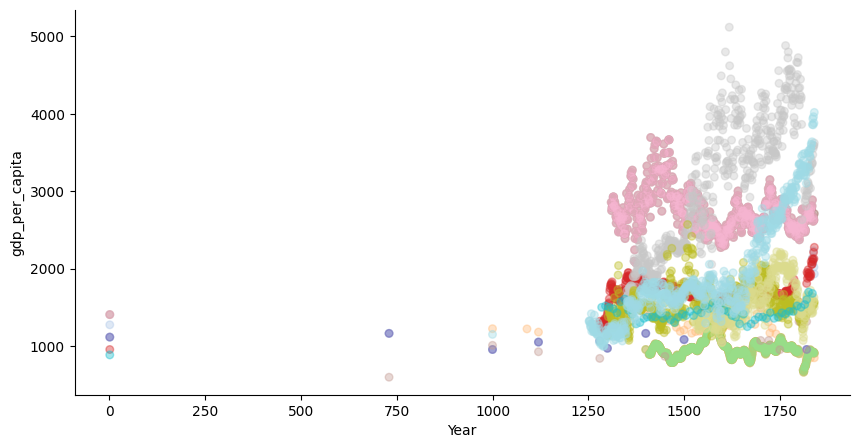

In [242]:
def plot_scatter(data, col="gdp_per_capita", ax=None, figsize=(10, 5)):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    ax.scatter(data["year"], data[col], c=data["region_name_id"], alpha=0.4, s=30)
    ax.set_xlabel("Year")
    ax.set_ylabel(col)
    ax.spines[['right', 'top']].set_visible(False)
    return ax

plot_scatter(df);

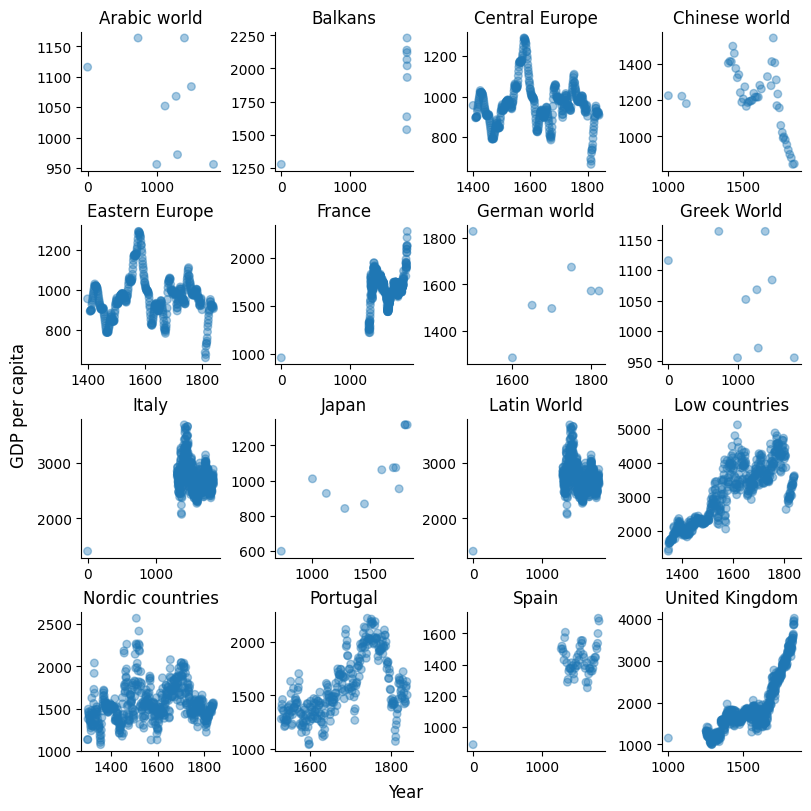

In [244]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(8, 8), constrained_layout=True)
for region, ax in zip(regions, axes.flatten()):
    sub_df = df.loc[df["region_name"] == region]
    plot_scatter(sub_df, ax=ax)
    ax.set(xlabel="", ylabel="", title=region)
fig.supylabel('GDP per capita')
fig.supxlabel('Year');

It's evident that the data largely concentrates post-1200, with scarce information preceding this timeline. This likely poses a modeling challenge, so for the present, let's focus our attention on the period succeeding 1200.

In [247]:
data = df.loc[df["year"] > 1200]
data["region_name"].value_counts()

region_name
United Kingdom      589
Nordic countries    541
France              531
Italy               531
Latin World         530
Low countries       487
Central Europe      423
Eastern Europe      423
Portugal            311
Spain                57
Chinese world        43
Japan                 9
Balkans               8
German world          7
Arabic world          5
Greek World           5
Name: count, dtype: int64

In [248]:
data = data.groupby("region_name").filter(lambda g: len(g) > 5)

Spline analysis necessitates the designation of basis function boundaries, known as knots. These knots partition the 'year' variable into $n$ continuous segments. As these basis functions constitute a piecewise continuous polynomial, they are mandated to converge at the knots. Given that we employ quantiles and lack observations for every year within the studied time window, the knots are asymmetrically distributed across the 'year' range. This results in an equivalent proportion of values falling between each segment. The following plot illustrates the knots shown as vertical grey lines:

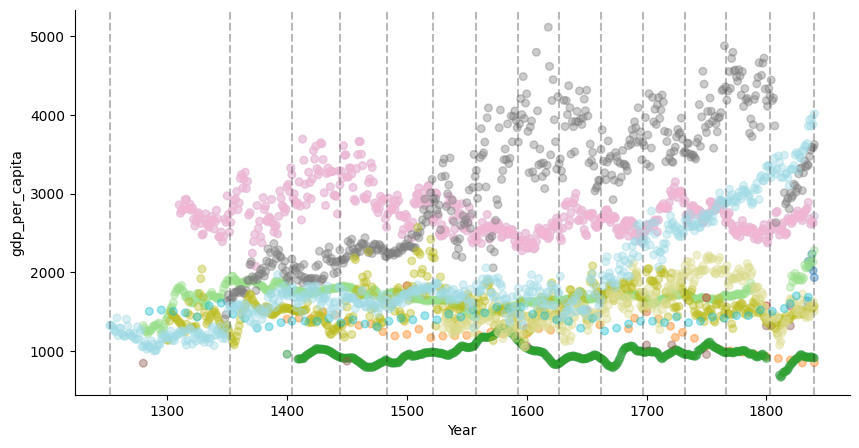

In [249]:
num_knots = 15
knots = np.quantile(data["year"], np.linspace(0, 1, num_knots))

def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", ls="--", alpha=0.3)
    return ax

ax = plot_scatter(data)
plot_knots(knots, ax);

The model is specified as follows:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \sum^K_{k = 1} w_k B_{k, i} + \beta x_i \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
w_j & \sim \text{Normal}(0, 10) \\
\sigma & \sim \text{Exponential}(1)
\end{align*},

which can be conveniently implememted with Bambi using:

In [250]:
iknots = knots[1:-1]

# Define dictionary of priors
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "sigma": bmb.Prior("Exponential", lam=1)
}

# Define model
m_spline = bmb.Model(
    "log_gdp_std ~ score_log_std + bs(year, knots=iknots, intercept=True)", 
    data, 
#     noncentered=True,
#     priors=priors
)
m_spline

       Formula: log_gdp_std ~ score_log_std + bs(year, knots=iknots, intercept=True)
        Family: gaussian
          Link: mu = identity
  Observations: 4490
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0005, sigma: 0.3829)
            score_log_std ~ Normal(mu: 0.0, sigma: 0.2749)
            bs(year, knots = iknots, intercept = True) ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
                0. 0. 0. 0.], sigma: [2.3567 1.4741 1.0083 0.759  0.8001 0.8434 0.8449 0.8238 0.8318 0.8395
             0.8387 0.8362 0.8276 0.8268 1.0561 1.187  1.2845])
        
        Auxiliary parameters
            log_gdp_std_sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0571)

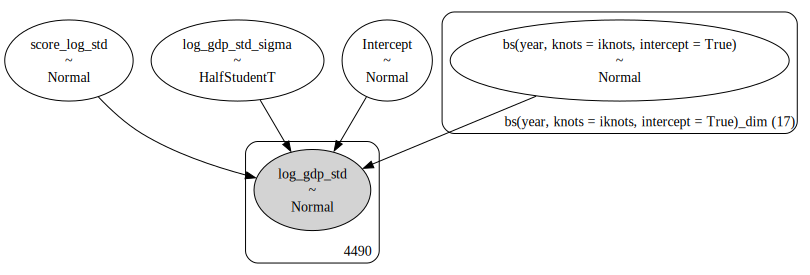

In [251]:
m_spline.build()
m_spline.graph()

In [252]:
m_spline_fit = m_spline.fit(
    tune=2000,
    draws=6000, 
    chains=4, 
    target_accept=0.9,
    inference_method='nuts_numpyro',
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ bs(year)"] = m_spline_fit
az.summary(m_spline_fit)

Compiling...
Compilation time =  0:00:02.223146
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time =  0:01:49.562073
Transforming variables...
Transformation time =  0:00:00.026049
Computing Log Likelihood...
Log Likelihood time =  0:00:06.368900


mean     sd  hdi_3%  hdi_97%   
Intercept                                       0.995  0.218   0.592    1.416  \
score_log_std                                  -0.008  0.002  -0.012   -0.005   
bs(year, knots = iknots, intercept = True)[0]  -0.049  0.219  -0.459    0.363   
bs(year, knots = iknots, intercept = True)[1]  -0.046  0.218  -0.464    0.359   
bs(year, knots = iknots, intercept = True)[2]   0.039  0.218  -0.371    0.452   
bs(year, knots = iknots, intercept = True)[3]   0.019  0.218  -0.387    0.438   
bs(year, knots = iknots, intercept = True)[4]   0.003  0.218  -0.396    0.428   
bs(year, knots = iknots, intercept = True)[5]   0.003  0.218  -0.399    0.424   
bs(year, knots = iknots, intercept = True)[6]   0.015  0.218  -0.382    0.443   
bs(year, knots = iknots, intercept = True)[7]   0.006  0.218  -0.417    0.407   
bs(year, knots = iknots, intercept = True)[8]   0.013  0.218  -0.379    0.445   
bs(year, knots = iknots, intercept = True)[9]   0.004  0.218  -0.388    0.435   
bs(year, knots = iknots, intercept = True)[10]  0.014  0.218  -0.381    0.443   
bs(year, knots = iknots, intercept = True)[11]  0.021  0.218  -0.386    0.437   
bs(year, knots = iknots, intercept = True)[12]  0.028  0.218  -0.387    0.437   
bs(year, knots = iknots, intercept = True)[13]  0.028  0.218  -0.375    0.448   
bs(year, knots = iknots, intercept = True)[14]  0.034  0.218  -0.380    0.444   
bs(year, knots = iknots, intercept = True)[15]  0.010  0.218  -0.408    0.415   
bs(year, knots = iknots, intercept = True)[16]  0.036  0.218  -0.386    0.439   
log_gdp_std_sigma                               0.056  0.001   0.055    0.057   

                                                mcse_mean  mcse_sd  ess_bulk   
Intercept                                           0.005    0.004    1888.0  \
score_log_std                                       0.000    0.000    9871.0   
bs(year, knots = iknots, intercept = True)[0]       0.005    0.004    1903.0   
bs(year, knots = iknots, intercept = True)[1]       0.005    0.004    1898.0   
bs(year, knots = iknots, intercept = True)[2]       0.005    0.004    1895.0   
bs(year, knots = iknots, intercept = True)[3]       0.005    0.004    1889.0   
bs(year, knots = iknots, intercept = True)[4]       0.005    0.004    1890.0   
bs(year, knots = iknots, intercept = True)[5]       0.005    0.004    1891.0   
bs(year, knots = iknots, intercept = True)[6]       0.005    0.004    1888.0   
bs(year, knots = iknots, intercept = True)[7]       0.005    0.004    1890.0   
bs(year, knots = iknots, intercept = True)[8]       0.005    0.004    1889.0   
bs(year, knots = iknots, intercept = True)[9]       0.005    0.004    1891.0   
bs(year, knots = iknots, intercept = True)[10]      0.005    0.004    1889.0   
bs(year, knots = iknots, intercept = True)[11]      0.005    0.004    1890.0   
bs(year, knots = iknots, intercept = True)[12]      0.005    0.004    1890.0   
bs(year, knots = iknots, intercept = True)[13]      0.005    0.004    1890.0   
bs(year, knots = iknots, intercept = True)[14]      0.005    0.004    1890.0   
bs(year, knots = iknots, intercept = True)[15]      0.005    0.004    1895.0   
bs(year, knots = iknots, intercept = True)[16]      0.005    0.004    1891.0   
log_gdp_std_sigma                                   0.000    0.000    7072.0   

                                                ess_tail  r_hat  
Intercept                                         2214.0    1.0  
score_log_std                                     8773.0    1.0  
bs(year, knots = iknots, intercept = True)[0]     2256.0    1.0  
bs(year, knots = iknots, intercept = True)[1]     2309.0    1.0  
bs(year, knots = iknots, intercept = True)[2]     2267.0    1.0  
bs(year, knots = iknots, intercept = True)[3]     2289.0    1.0  
bs(year, knots = iknots, intercept = True)[4]     2249.0    1.0  
bs(year, knots = iknots, intercept = True)[5]     2237.0    1.0  
bs(year, knots = iknots, intercept = True)[6]     2269.0    1.0  
bs(yea

As we're neglecting regional variations, it's unlikely this model will yield a notably good fit. However, let's proceed to swiftly examine the posterior predictions.

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


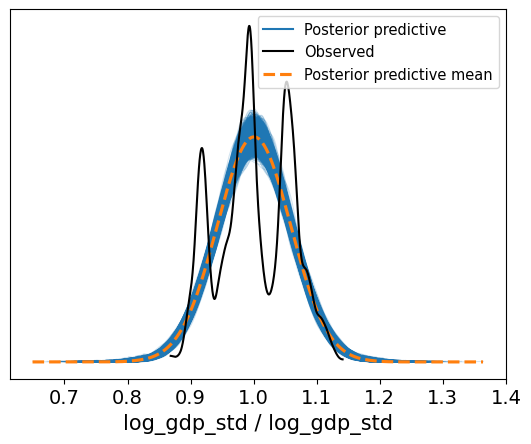

In [253]:
m_spline.predict(m_spline_fit, kind="pps")
az.plot_ppc(m_spline_fit);

We illustrate the predicted mean GDP values (logged and standardized), alongside their credible intervals. The subsequent plot reveals the model's adaptability in accommodating fluctuations in GDP values. However, it exhibits excessive confidence in its intervals, implying significantly less variation than what actually exists.

In [254]:
def plot_predictions(data, new_data, idata, model, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    # Create a test dataset with observations spanning the whole range of year
    model.predict(idata, data=new_data)
    posterior_stacked = az.extract(idata)
    y_hat = posterior_stacked["log_gdp_std_mean"]

    # Compute the mean of the predictions, plotted as a single line.
    y_hat_mean = y_hat.mean("sample")
    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(y_hat, [0.03, 0.97], axis=1)
    # Plot obserevd data
    ax = plot_scatter(data, "log_gdp_std", ax=ax)
    # Plot predicted line
    ax.plot(new_data["year"], y_hat_mean, color="firebrick")
    # Plot credibility bands
    ax.fill_between(new_data["year"], hdi_data[0], hdi_data[1], alpha=0.4, color="firebrick")
    # Add knots
    plot_knots(knots, ax)

    return ax

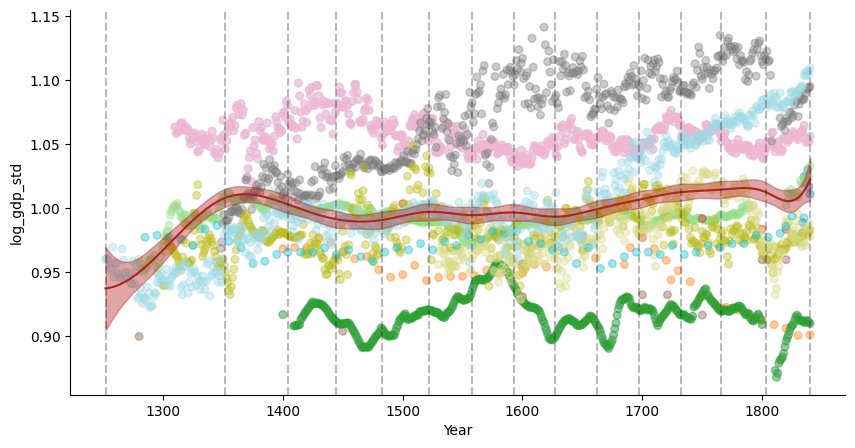

In [255]:
new_data = pd.DataFrame({
    "year": np.linspace(data.year.min(), data.year.max(), num=500),
    "score_log_std": np.ones(500)
})

fig, ax = plt.subplots(figsize=(10, 5))
plot_predictions(data, new_data, m_spline_fit, m_spline, ax=ax);

Let's try improve on the model by first incorporating regional differences as varying intercepts. The model specification is as follows:

\begin{align*}
\log(\text{GDP}_i) & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i & = \alpha + \alpha_{\text{region}[i]} + \sum^K_{k = 1} w_k B_{k, i} + \beta x_i \\
\alpha_\text{region} & \sim \text{Normal}(0, \sigma_{\text{region}}) \\
\alpha & \sim \text{Normal}(1, 1) \\
\beta & \sim \text{Normal}(0, 1) \\
w_j & \sim \text{Normal}(0, 10) \\
\sigma_{\alpha} & \sim \text{HalfNormal}(1) \\
\sigma & \sim \text{Exponential}(1)
\end{align*},

In [257]:
# Define dictionary of priors
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "score_log_std": bmb.Prior("Normal", mu=0, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "sigma": bmb.Prior("Exponential", lam=1)
}
# Define model
m_spline_vi = bmb.Model(
    "log_gdp_std ~ score_log_std + bs(year, knots=iknots, intercept=True) + (1|region_name)", 
    data, 
#     noncentered=True,
#     priors=priors
)
m_spline_vi

       Formula: log_gdp_std ~ score_log_std + bs(year, knots=iknots, intercept=True) + (1|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 4490
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0005, sigma: 0.3829)
            score_log_std ~ Normal(mu: 0.0, sigma: 0.2749)
            bs(year, knots = iknots, intercept = True) ~ Normal(mu: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
                0. 0. 0. 0.], sigma: [2.3567 1.4741 1.0083 0.759  0.8001 0.8434 0.8449 0.8238 0.8318 0.8395
             0.8387 0.8362 0.8276 0.8268 1.0561 1.187  1.2845])
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3829))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0571)

In [258]:
m_spline_vi_fit = m_spline_vi.fit(
    tune=2000,
    draws=6000, 
    chains=4, 
    target_accept=0.9,
    inference_method='nuts_numpyro',
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_log_std + bs(year) + (1|region_name)"] = m_spline_vi_fit
az.summary(m_spline_vi_fit)

Compiling...
Compilation time =  0:00:02.231845
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time =  0:08:54.559518
Transforming variables...
Transformation time =  0:00:00.033149
Computing Log Likelihood...
Log Likelihood time =  0:00:09.017068


mean     sd  hdi_3%  hdi_97%   
Intercept                                       0.947  0.227   0.519    1.367  \
score_log_std                                   0.029  0.002   0.026    0.033   
bs(year, knots = iknots, intercept = True)[0]  -0.039  0.226  -0.457    0.393   
bs(year, knots = iknots, intercept = True)[1]  -0.011  0.226  -0.427    0.426   
bs(year, knots = iknots, intercept = True)[2]   0.016  0.226  -0.402    0.449   
bs(year, knots = iknots, intercept = True)[3]   0.012  0.226  -0.417    0.435   
bs(year, knots = iknots, intercept = True)[4]   0.026  0.226  -0.395    0.455   
bs(year, knots = iknots, intercept = True)[5]   0.001  0.226  -0.422    0.430   
bs(year, knots = iknots, intercept = True)[6]   0.016  0.226  -0.396    0.456   
bs(year, knots = iknots, intercept = True)[7]   0.004  0.226  -0.403    0.449   
bs(year, knots = iknots, intercept = True)[8]   0.009  0.226  -0.406    0.446   
bs(year, knots = iknots, intercept = True)[9]  -0.001  0.226  -0.407    0.445   
bs(year, knots = iknots, intercept = True)[10]  0.008  0.226  -0.419    0.433   
bs(year, knots = iknots, intercept = True)[11]  0.016  0.226  -0.405    0.447   
bs(year, knots = iknots, intercept = True)[12]  0.014  0.226  -0.397    0.455   
bs(year, knots = iknots, intercept = True)[13]  0.018  0.226  -0.389    0.463   
bs(year, knots = iknots, intercept = True)[14]  0.006  0.226  -0.426    0.426   
bs(year, knots = iknots, intercept = True)[15] -0.013  0.226  -0.431    0.421   
bs(year, knots = iknots, intercept = True)[16]  0.012  0.226  -0.395    0.457   
log_gdp_std_sigma                               0.021  0.000   0.020    0.021   
1|region_name_sigma                             0.057  0.013   0.037    0.081   
1|region_name[Balkans]                          0.019  0.018  -0.016    0.051   
1|region_name[Central Europe]                  -0.074  0.016  -0.105   -0.044   
1|region_name[Chinese world]                   -0.036  0.016  -0.067   -0.005   
1|region_name[Eastern Europe]                  -0.077  0.016  -0.109   -0.048   
1|region_name[France]                           0.001  0.016  -0.030    0.031   
1|region_name[German world]                    -0.025  0.018  -0.057    0.009   
1|region_name[Italy]                            0.060  0.016   0.028    0.089   
1|region_name[Japan]                           -0.045  0.017  -0.078   -0.012   
1|region_name[Latin World]                      0.095  0.016   0.064    0.125   
1|region_name[Low countries]                    0.076  0.016   0.045    0.106   
1|region_name[Nordic countries]                 0.001  0.016  -0.030    0.031   
1|region_name[Portugal]                         0.005  0.016  -0.026    0.035   
1|region_name[Spain]                           -0.016  0.016  -0.048    0.014   
1|region_name[United Kingdom]                   0.018  0.016  -0.012    0.048   

                                                mcse_mean  mcse_sd  ess_bulk   
Intercept                                           0.006    0.005    1263.0  \
score_log_std                                       0.000    0.000   29878.0   
bs(year, knots = iknots, intercept = True)[0]       0.006    0.005    1258.0   
bs(year, knots = iknots, intercept = True)[1]       0.006    0.005    1259.0   
bs(year, knots = iknots, intercept = True)[2]       0.006    0.005    1259.0   
bs(year, knots = iknots, intercept = True)[3]       0.006    0.005    1258.0   
bs(year, knots = iknots, intercept = True)[4]       0.006    0.005    1258.0   
bs(year, knots = iknots, intercept = True)[5]       0.006    0.005    1259.0   
bs(year, knots = iknots, intercept = True)[6]       0.006    0.005    1258.0   
bs(year, knots = iknots, intercept = True)[7]       0.006    0.005    1258.0   
bs(year, knots = iknots, intercept = True)[8]       0.006    0.005    1259.0   
bs(year, knots = iknots, intercept = True)[9]       0.006    0.005    1257.0   
bs(year, knots = iknots, intercept = True)[10]      0.006    0.005    1258.0   
bs(year, kno

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


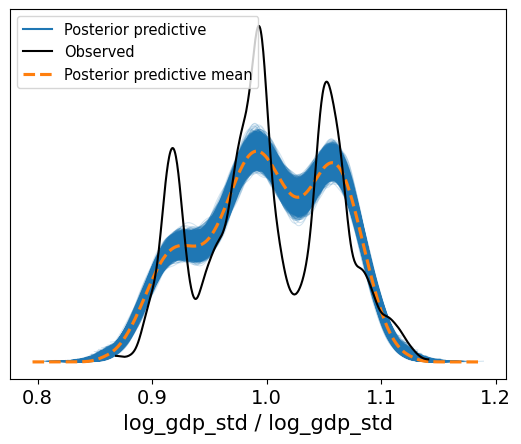

In [259]:
m_spline_vi.predict(m_spline_vi_fit, kind="pps")
az.plot_ppc(m_spline_vi_fit);

In [260]:
data["region_name"].nunique()

14

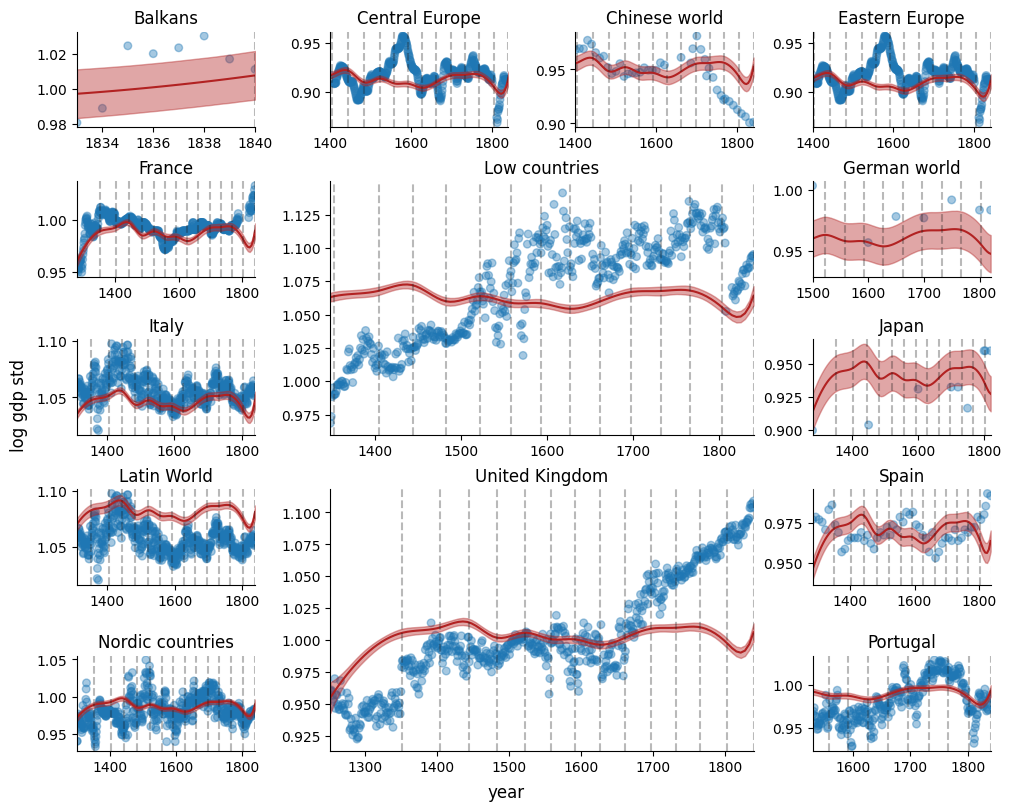

In [281]:
grid = [
    ["Balkans", "Central Europe", "Chinese world", "Eastern Europe"],
    ["France", "Low countries", "Low countries", "German world"],
    ["Italy", "Low countries", "Low countries", "Japan"],
    ["Latin World", "United Kingdom", "United Kingdom", "Spain"],
    ["Nordic countries", "United Kingdom", "United Kingdom", "Portugal"]
]

fig, axes = plt.subplot_mosaic(grid, figsize=(10, 8), layout='constrained')
regions = data["region_name"].unique()

for region in regions:
    subset = data[data["region_name"] == region]
    min_year, max_year = subset["year"].min(), subset["year"].max()
    new_data = pd.DataFrame({
        "year": np.linspace(min_year, max_year, num=100),
        "score_log_std": np.ones(100),
        "region_name": np.array([region] * 100)
    })

    ax = plot_predictions(subset, new_data, m_spline_vi_fit, m_spline_vi, ax=axes[region])
    ax.set(xlim=(min_year, max_year), title=region, ylabel="", xlabel="")
    
fig.supylabel('log gdp std')
fig.supxlabel('year');

In [282]:
# Define dictionary of priors
priors = {
    "Intercept": bmb.Prior("Normal", mu=1, sigma=1),
    "common": bmb.Prior("Normal", mu=0, sigma=1),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=1)),
    "bs(year, knots = iknots, intercept = True)|region_name": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2.5)),
    "sigma": bmb.Prior("Exponential", lam=1)
}
# Define model
m_spline_vs = bmb.Model(
    "log_gdp_std ~ 1 + score_log_std + (bs(year, knots=iknots, intercept=True)|region_name)", 
    data, 
#     noncentered=True,
#     priors=priors
)
m_spline_vs

       Formula: log_gdp_std ~ 1 + score_log_std + (bs(year, knots=iknots, intercept=True)|region_name)
        Family: gaussian
          Link: mu = identity
  Observations: 4490
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 1.0005, sigma: 0.3107)
            score_log_std ~ Normal(mu: 0.0, sigma: 0.2749)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3107))
            bs(year, knots = iknots, intercept = True)|region_name ~ Normal(mu: 0.0, sigma:
                HalfNormal(sigma: [2.3567 1.4741 1.0083 0.759  0.8001 0.8434 0.8449 0.8238 0.8318 0.8395
             0.8387 0.8362 0.8276 0.8268 1.0561 1.187  1.2845]))
        
        Auxiliary parameters
            log_gdp_std_sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0571)

In [283]:
m_spline_vs_fit = m_spline_vs.fit(
    tune=2000,
    draws=6000, 
    chains=4, 
    target_accept=0.9,
    inference_method='nuts_numpyro',
    idata_kwargs={"log_likelihood": True})

models["log_gdp_std ~ score_log_std + (bs(year)|region_name)"] = m_spline_vs_fit
az.summary(m_spline_vs_fit)

Compiling...
Compilation time =  0:00:03.418389
Sampling...


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

Sampling time =  1:08:17.857720
Transforming variables...
Transformation time =  0:00:00.093839
Computing Log Likelihood...
Log Likelihood time =  0:14:55.969264


mean     sd  hdi_3%   
Intercept                                           0.986  0.016   0.956  \
score_log_std                                       0.000  0.002  -0.004   
log_gdp_std_sigma                                   0.009  0.000   0.009   
1|region_name_sigma                                 0.056  0.013   0.036   
bs(year, knots = iknots, intercept = True)|regi...  0.178  0.083   0.057   
...                                                   ...    ...     ...   
bs(year, knots = iknots, intercept = True)|regi...  0.034  0.008   0.019   
bs(year, knots = iknots, intercept = True)|regi... -0.002  0.007  -0.015   
bs(year, knots = iknots, intercept = True)|regi...  0.012  0.009  -0.004   
bs(year, knots = iknots, intercept = True)|regi...  0.025  0.017  -0.007   
bs(year, knots = iknots, intercept = True)|regi...  0.102  0.008   0.086   

                                                    hdi_97%  mcse_mean   
Intercept                                             1.016      0.000  \
score_log_std                                         0.004      0.000   
log_gdp_std_sigma                                     0.010      0.000   
1|region_name_sigma                                   0.080      0.000   
bs(year, knots = iknots, intercept = True)|regi...    0.325      0.001   
...                                                     ...        ...   
bs(year, knots = iknots, intercept = True)|regi...    0.049      0.000   
bs(year, knots = iknots, intercept = True)|regi...    0.012      0.000   
bs(year, knots = iknots, intercept = True)|regi...    0.028      0.000   
bs(year, knots = iknots, intercept = True)|regi...    0.057      0.000   
bs(year, knots = iknots, intercept = True)|regi...    0.117      0.000   

                                                    mcse_sd  ess_bulk   
Intercept                                             0.000    6244.0  \
score_log_std                                         0.000   24448.0   
log_gdp_std_sigma                                     0.000   35960.0   
1|region_name_sigma                                   0.000    8180.0   
bs(year, knots = iknots, intercept = True)|regi...    0.001    9345.0   
...                                                     ...       ...   
bs(year, knots = iknots, intercept = True)|regi...    0.000    8642.0   
bs(year, knots = iknots, intercept = True)|regi...    0.000    8746.0   
bs(year, knots = iknots, intercept = True)|regi...    0.000    6034.0   
bs(year, knots = iknots, intercept = True)|regi...    0.000   27275.0   
bs(year, knots = iknots, intercept = True)|regi...    0.000    5778.0   

                                                    ess_tail  r_hat  
Intercept                                             9856.0    1.0  
score_log_std                                        19256.0    1.0  
log_gdp_std_sigma                                    15912.0    1.0  
1|region_name_sigma                                  11488.0    1.0  
bs(year, knots = iknots, intercept = True)|regi...   10669.0    1.0  
...                                                      ...    ...  
bs(year, knots = iknots, intercept = True)|regi...   14900.0    1.0  
bs(year, knots = iknots, intercept = True)|regi...   14651.0    1.0  
bs(year, knots = iknots, intercept = True)|regi...   10596.0    1.0  
bs(year, knots = iknots, intercept = True)|regi...   19444.0    1.0  
bs(year, knots = iknots, intercept = True)|regi...   11731.0    1.0  

[273 rows x 9 columns]

/usr/local/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


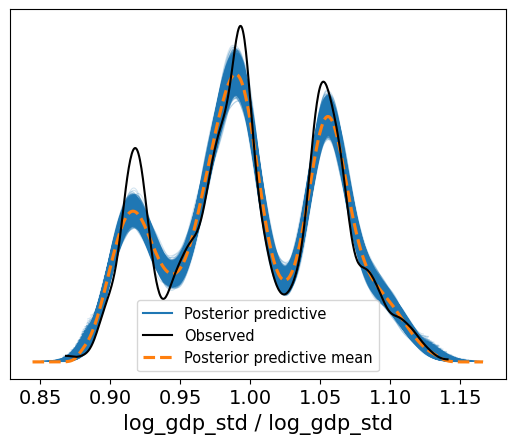

In [284]:
m_spline_vs.predict(m_spline_vs_fit, kind="pps")
az.plot_ppc(m_spline_vs_fit);

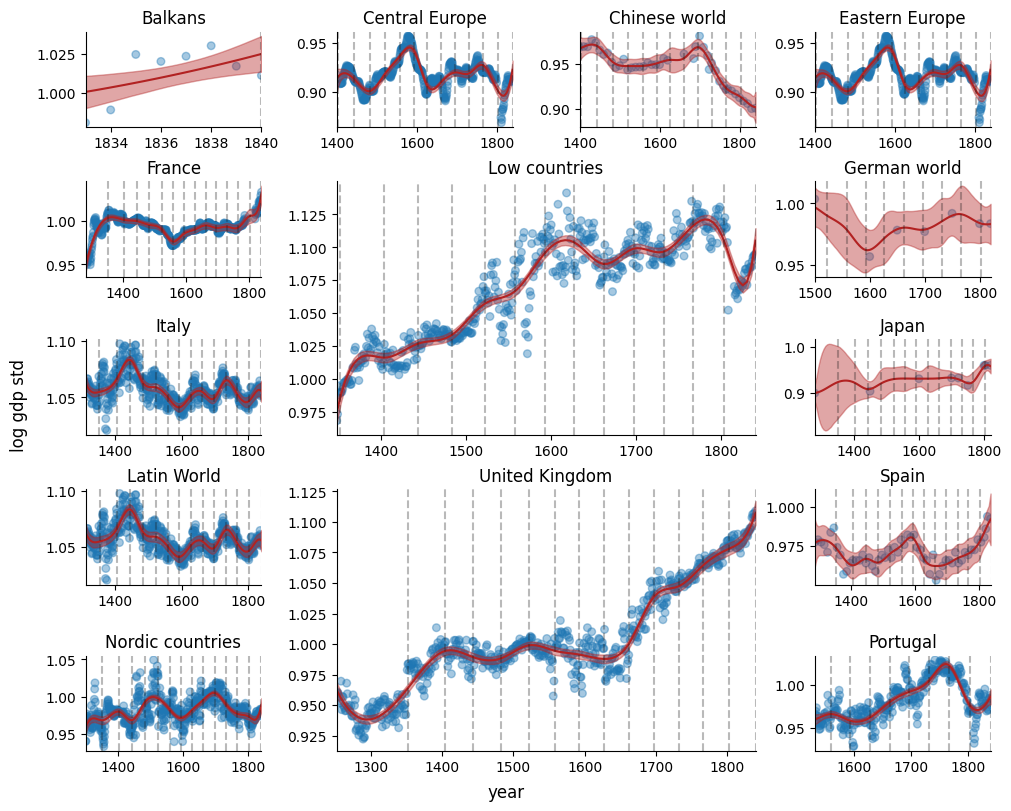

In [285]:
fig, axes = plt.subplot_mosaic(grid, figsize=(10, 8), layout='constrained')

for region in regions:
    subset = data[data["region_name"] == region]
    min_year, max_year = subset["year"].min(), subset["year"].max()
    new_data = pd.DataFrame({
        "year": np.linspace(min_year, max_year, num=100),
        "score_log_std": np.ones(100),
        "region_name": np.array([region] * 100)
    })

    ax = plot_predictions(subset, new_data, m_spline_vs_fit, m_spline_vs, ax=axes[region])
    ax.set(xlim=(min_year, max_year), title=region, ylabel="", xlabel="")
    
fig.supylabel('log gdp std')
fig.supxlabel('year');